In [1]:
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta
import numpy as np
import os
import sys
import shutil
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from op_coreutils.gcpauth import get_credentials
from google.cloud import bigquery
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

sys.path.append("../../helper_functions")
import defillama_utils as dfl
# import duneapi_utils as d
import csv_utils as cu
import google_bq_utils as bqu

import urllib3
import warnings

urllib3.disable_warnings()
warnings.filterwarnings("ignore")

2024-11-06 16:33:33 [info     ] Loaded env var: OP_ANALYTICS_VAULT


In [2]:
# date ranges to build charts for
drange = [1, 3, 7, 14, 30, 90]
load_num_days = 14
# Do we count net flows marked at the lastest token price (1) or the price on each day (0)
# By default, we opt to 1, so that price movement isn't accidentally counted as + or - flow remainder
mark_at_latest_price = (
    1  # some errors with missing token prices we need to find solves for first
)

trailing_num_days = max(drange)
# print(trailing_num_days)
last_date = datetime.utcnow().date() - timedelta(days=1)
start_date = last_date - timedelta(days=trailing_num_days)
load_start_date = last_date - timedelta(days=load_num_days)
# Convert to Pandas Timestamp
last_date = pd.to_datetime(last_date)
start_date = pd.to_datetime(start_date)

print(start_date)
print(last_date)

2024-08-07 00:00:00
2024-11-05 00:00:00


In [3]:
# get all apps > x m tvl
all_tvl_floor = 0
min_tvl = 10 *1e6
# if TVL by token is not available, do we fallback on raw TVL (sensitive to token prices)?
is_fallback_on_raw_tvl = True  # False

df_all = dfl.get_all_protocol_tvls_by_chain_and_token(min_tvl = all_tvl_floor, fallback_on_raw_tvl = is_fallback_on_raw_tvl, start_date = start_date)#write_bq_dataset='api_table_uploads', write_bq_table='daily_defillama_tvl_full_breakdown')
# df_all = dfl.get_all_protocol_tvls_by_chain_and_token(
#     min_tvl=all_tvl_floor, 
#     fallback_on_raw_tvl=is_fallback_on_raw_tvl, 
#     start_date=start_date
# )

Number of Apps: 4042
Number of Rows: 10980062


In [3]:
client = bigquery.Client(credentials=get_credentials())


2024-11-06 16:33:35 [info     ] Loaded 15 items into vault.   
2024-11-06 16:33:35 [info     ] gcpauth.py: vault variable GOOGLE_SERVICE_ACCOUNT is not configured. Will use default auth process.


In [4]:
query = """
SELECT
  date,
  CASE WHEN chain = 'OP Mainnet' THEN 'Optimism' ELSE chain END AS chain,
  tvl.tvl AS tvl
FROM `api_table_uploads.daily_defillama_chain_tvl` tvl 
WHERE chain IN ('Ethereum', 'Solana', 'Arbitrum', 'Base', 'OP Mainnet', 'Mode')
AND date >= '2023-10-29'
UNION ALL
SELECT
  date,
  'Superchain' AS chain,
  SUM(tvl.tvl) AS tvl
FROM `api_table_uploads.daily_defillama_chain_tvl` tvl 
WHERE alignment = 'OP Chain'
AND date >= '2023-10-29'
GROUP BY 1
"""
query_job = client.query(query)
results = query_job.result()
data = [dict(row) for row in results]
total_tvl_df = pd.DataFrame(data)


In [5]:
metadata_dict = {
    "Metis": "OP Stack fork",
    "Blast": "OP Stack fork",
    "Mantle": "OP Stack fork",
    "Zircuit": "OP Stack fork",
    "RSS3": "OP Stack fork",
    "Rollux": "OP Stack fork",
    "Ancient8": "OP Stack fork",
    "Manta": "OP Stack fork",
    "Cyber": "OP Chain",
    "Mint": "OP Chain",
    "Ham": "OP Chain",
    "Polynomial": "OP Chain",
    "Lisk": "OP Chain",
    "BOB": "OP Chain",
    "Mode": "OP Chain",
    "World Chain": "OP Chain",
    "Base": "OP Chain",
    "Kroma": "OP Chain",
    "Boba": "OP Chain",
    "Fraxtal": "OP Chain",
    "Optimism": "OP Chain",
    "Shape": "OP Chain",
    "Zora": "OP Chain"
}

metadata_df = pd.DataFrame(list(metadata_dict.items()), columns=["chain", "alignment"])


token_data = [
    {"token": "ETH", "token_category": "Native Asset"},
    {"token": "WETH", "token_category": "Native Asset"},
    {"token": "SOL", "token_category": "Native Asset"},
    {"token": "wBTC", "token_category": "Wrapped Assets"},
    {"token": "cbBTC", "token_category": "Wrapped Assets"},
    {"token": "MBTC", "token_category": "Wrapped Assets"},

    {"token": "stETH", "token_category": "Liquid Staking"},
    {"token": "wstETH", "token_category": "Liquid Staking"},
    {"token": "eETH", "token_category": "Liquid Restaking"},
    {"token": "weETH", "token_category": "Liquid Restaking"},
    {"token": "sfrxETH", "token_category": "Liquid Staking"},
    {"token": "rETH", "token_category": "Liquid Staking"},
    {"token": "mETH", "token_category": "Liquid Staking"},
    {"token": "rsETH", "token_category": "Liquid Restaking"},
    {"token": "cbETH", "token_category": "Liquid Staking"},
    {"token": "ezETH", "token_category": "Liquid Restaking"},
    {"token": "rswETH", "token_category": "Liquid Restaking"},
    {"token": "swETH", "token_category": "Liquid Staking"},
    {"token": "frxETH", "token_category": "Liquid Staking"},
    {"token": "ETHX", "token_category": "Liquid Staking"},
    {"token": "lsETH", "token_category": "Liquid Staking"},
    {"token": "oETH", "token_category": "Liquid Staking"},
    {"token": "EBTC", "token_category": "Liquid Restaking"},
    {"token": "LBTC", "token_category": "Liquid Restaking"},

    {"token": "SUPEROETHB", "token_category": "Liquid Staking"},
    {"token": "WSUPEROETHB", "token_category": "Liquid Staking"},
    {"token": "TETH", "token_category": "Liquid Staking"},
    {"token": "OSETH", "token_category": "Liquid Staking"},
    {"token": "cmETH", "token_category": "Liquid Restaking"},
    {"token": "USDC", "token_category": "Stablecoins"},
    {"token": "USDT", "token_category": "Stablecoins"},
    {"token": "FDUSD", "token_category": "Stablecoins"},
    {"token": "PYUSD", "token_category": "Stablecoins"},
    {"token": "TUSD", "token_category": "Stablecoins"},
    {"token": "DAI", "token_category": "Stablecoins"},
    {"token": "USDe", "token_category": "Stablecoins"},
    {"token": "USDD", "token_category": "Stablecoins"},
    {"token": "FRAX", "token_category": "Stablecoins"},
    {"token": "EURC", "token_category": "Stablecoins"},
    {"token": "AGEUR", "token_category": "Stablecoins"},
    {"token": "USDS", "token_category": "Stablecoins"},
    {"token": "USDB", "token_category": "Stablecoins"},
    {"token": "MSOL", "token_category": "Liquid Staking"},
    {"token": "JUPSOL", "token_category": "Liquid Staking"},
    {"token": "BNSOL", "token_category": "Liquid Staking"},
    {"token": "SSOL", "token_category": "Liquid Restaking"},
    {"token": "BBSOL", "token_category": "Liquid Restaking"},
    {"token": "LAINESOL", "token_category": "Liquid Staking"},
    {"token": "STSOL", "token_category": "Liquid Staking"},
    {"token": "STRONGSOL", "token_category": "Liquid Staking"},
    {"token": "HUBSOL", "token_category": "Liquid Staking"},
    {"token": "PATHSOL", "token_category": "Liquid Staking"},
    {"token": "STEPSOL", "token_category": "Liquid Staking"},
    {"token": "EDGESOL", "token_category": "Liquid Staking"},
    {"token": "JITOSOL", "token_category": "Liquid Staking"},
    {"token": "DSOL", "token_category": "Liquid Staking"},
    {"token": "BONKSOL", "token_category": "Liquid Staking"},
    {"token": "VSOL", "token_category": "Liquid Staking"},
    {"token": "HSOL", "token_category": "Liquid Staking"},
    # {"token": "ARB", "token_category": "Layer 2 Token"},
    # {"token": "OP", "token_category": "Layer 2 Token"},
    # {"token": "MODE", "token_category": "Layer 2 Token"},


]

token_categories = pd.DataFrame(token_data)

token_categories["token"] = token_categories["token"].str.upper()

In [6]:
# ## Checkpoint
# # df_all.to_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_20221110_to_20241031.csv", index=False)

# # df_all = pd.read_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_20221110_to_20241031.csv")
# df_all = pd.read_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_202301104_to_20241030.csv")

# df_all["date"] = pd.to_datetime(df_all["date"], format="mixed")
# # df_all["date_trunc"] = df_all.date.dt.date






In [8]:

# df_all = pd.read_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_202301104_to_20241030.csv")

df_all = pd.merge(df_all, metadata_df, on="chain", how="left")

df_all["date"] = pd.to_datetime(df_all["date"], format="mixed")

df_filtered = df_all[
    (df_all["date"].dt.time == pd.Timestamp("00:00:00").time())
    &
    (df_all.alignment.isin(["OP Chain", "OP Stack Fork"])
    | df_all.chain.isin(["Ethereum", "Arbitrum", "Solana"]))
]




In [9]:

# # Define the file path and the filter criteria
# file_path = "/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_202301104_to_20241030.csv"
# chunksize = 100000  # Adjust based on your memory constraints

# # Placeholder for the filtered results
# filtered_chunks = []

# # Process each chunk
# for chunk in pd.read_csv(file_path, chunksize=chunksize):
#     # Convert the 'date' column to datetime within each chunk
#     chunk["date"] = pd.to_datetime(chunk["date"], format="mixed", errors="coerce")  # `errors="coerce"` handles non-datetime entries as NaT

#     # Filter the chunk based on the conditions
#     df_filtered_chunk = chunk[
#         (chunk["date"].dt.time == pd.Timestamp("00:00:00").time()) &
#         (chunk["alignment"].isin(["OP Chain", "OP Stack Fork"]) | chunk["chain"].isin(["Ethereum", "Arbitrum", "Solana"]))
#     ]

#     # Append the filtered chunk to the list
#     filtered_chunks.append(df_filtered_chunk)

# # Concatenate all the filtered chunks into a single DataFrame
# df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# # Display or further process df_filtered
# print(f"Number of rows in filtered DataFrame: {len(df_filtered)}")


Number of rows in filtered DataFrame: 15161402


In [9]:
df_filtered["parent_protocol"] = df_filtered["parent_protocol"].str.replace("parent#", "")

df_filtered["token"] = df_filtered["token"].str.upper()
df_filtered = pd.merge(df_filtered, token_categories, on="token", how="left")
df_filtered['token_category'] = df_filtered['token_category'].fillna("Other")

In [10]:
df_filtered

date  token   token_value     usd_value  total_app_tvl  \
0       2024-08-07   WETH  9.816089e+06  2.442263e+10   2.446001e+10   
1       2024-08-07  MATIC  9.039726e+07  3.737963e+07   2.446001e+10   
2       2024-08-08   WETH  9.827644e+06  2.301467e+10   2.305036e+10   
3       2024-08-08  MATIC  9.041586e+07  3.568696e+07   2.305036e+10   
4       2024-08-09   WETH  9.809853e+06  2.525929e+10   2.529746e+10   
...            ...    ...           ...           ...            ...   
4167404 2024-11-04   WETH  1.342438e+01  3.297712e+04   3.297712e+04   
4167405 2024-11-04    ETH  0.000000e+00  0.000000e+00   3.297712e+04   
4167406 2024-11-05    FXS  0.000000e+00  0.000000e+00   3.229060e+04   
4167407 2024-11-05   WETH  1.342438e+01  3.229060e+04   3.229060e+04   
4167408 2024-11-05    ETH  0.000000e+00  0.000000e+00   3.229060e+04   

         latest_total_app_tvl      protocol          slug     chain  \
0                2.603440e+10          lido          lido  Ethereum   
1                2.603440e+10          lido          lido  Ethereum   
2                2.603440e+10          lido          lido  Ethereum   
3                2.603440e+10          lido          lido  Ethereum   
4                2.603440e+10          lido          lido  Ethereum   
...                       ...           ...           ...       ...   
4167404          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167405          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167406          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167407          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167408          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   

               category          name parent_protocol  to_filter_out  \
0        Liquid Staking          Lido            Lido              0   
1        Liquid Staking          Lido            Lido              0   
2        Liquid Staking          Lido            Lido              0   
3        Liquid Staking          Lido            Lido              0   
4        Liquid Staking          Lido            Lido              0   
...                 ...           ...             ...            ...   
4167404             CDP  MahaDAO Arth         mahadao              0   
4167405             CDP  MahaDAO Arth         mahadao              0   
4167406             CDP  MahaDAO Arth         mahadao              0   
4167407             CDP  MahaDAO Arth         mahadao              0   
4167408             CDP  MahaDAO Arth         mahadao              0   

        alignment token_category  
0             NaN   Native Asset  
1             NaN          Other  
2             NaN   Native Asset  
3             NaN          Other  
4             NaN   Native Asset  
...           ...            ...  
4167404       NaN   Native Asset  
4167405       NaN   Native Asset  
4167406       NaN          Other  
4167407       NaN   Native Asset  
4167408       NaN   Native Asset  

[4167409 rows x 15 columns]

In [7]:
# df_filtered.to_csv("/Users/chuck/data/ad_hoc/df_filtered_20230807_to_20241105.csv", index=False)
df_filtered = pd.read_csv("/Users/chuck/data/ad_hoc/df_filtered_20230807_to_20241105.csv")


In [8]:
todays_date = "2024-11-05"
today_df = df_filtered[df_filtered.date == todays_date]

In [9]:
today_df

date  token   token_value     usd_value  total_app_tvl  \
180      2024-11-05   WETH  9.752912e+06  2.332770e+10   2.335076e+10   
181      2024-11-05  MATIC  8.056742e+07  2.306484e+07   2.335076e+10   
272      2024-11-05    SOL  8.559617e+04  1.346856e+07   1.346856e+07   
3603     2024-11-05   AAVE  1.148745e+06  1.476367e+08   1.055196e+10   
3604     2024-11-05   WBTC  3.533177e+04  2.387509e+09   1.055196e+10   
...             ...    ...           ...           ...            ...   
4167044  2024-11-05   USDC  8.028838e+03  8.023788e+03   3.347566e+04   
4167135  2024-11-05    APE  3.546244e+04  3.269289e+04   3.269289e+04   
4167406  2024-11-05    FXS  0.000000e+00  0.000000e+00   3.229060e+04   
4167407  2024-11-05   WETH  1.342438e+01  3.229060e+04   3.229060e+04   
4167408  2024-11-05    ETH  0.000000e+00  0.000000e+00   3.229060e+04   

         latest_total_app_tvl      protocol          slug     chain  \
180              2.603440e+10          lido          lido  Ethereum   
181              2.603440e+10          lido          lido  Ethereum   
272              1.596625e+07          lido          lido    Solana   
3603             1.175163e+10       aave-v3       aave-v3  Ethereum   
3604             1.175163e+10       aave-v3       aave-v3  Ethereum   
...                       ...           ...           ...       ...   
4167044          3.622809e+04       bridgem       bridgem  Ethereum   
4167135          3.600491e+04       nf3-ape       nf3-ape  Ethereum   
4167406          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167407          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   
4167408          3.578510e+04  mahadao-arth  mahadao-arth  Ethereum   

               category          name parent_protocol  to_filter_out  \
180      Liquid Staking          Lido            Lido              0   
181      Liquid Staking          Lido            Lido              0   
272      Liquid Staking          Lido            Lido              0   
3603            Lending       AAVE V3            aave              0   
3604            Lending       AAVE V3            aave              0   
...                 ...           ...             ...            ...   
4167044          Bridge       BridgeM         BridgeM              0   
4167135  Liquid Staking       NF3 APE         NF3 APE              0   
4167406             CDP  MahaDAO Arth         mahadao              0   
4167407             CDP  MahaDAO Arth         mahadao              0   
4167408             CDP  MahaDAO Arth         mahadao              0   

        alignment  token_category  
180           NaN    Native Asset  
181           NaN           Other  
272           NaN    Native Asset  
3603          NaN           Other  
3604          NaN  Wrapped Assets  
...           ...             ...  
4167044       NaN     Stablecoins  
4167135       NaN           Other  
4167406       NaN           Other  
4167407       NaN    Native Asset  
4167408       NaN    Native Asset  

[45738 rows x 15 columns]

In [10]:
# superchain_totals = (
#     today_df[today_df["alignment"] == "OP Chain"].groupby("token_category")["usd_value"].sum()
# )

# # Create a new DataFrame row for the combined "OP Chain" with the total values
# op_chain_row = pd.DataFrame(superchain_totals).transpose()
# op_chain_row["chain"] = "Superchain"
# op_chain_row["Grand Total"] = op_chain_row[
#     [
#         "Layer 2 Token",
#         "Liquid Restaking",
#         "Liquid Staking",
#         "Native Asset",
#         "Other",
#         "Stablecoins",
#         "Wrapped Assets",
#     ]
# ].sum(axis=1)

# Sum `usd_value` by token_category for rows where alignment is "OP Chain"
op_chain_totals = today_df[today_df["alignment"] == "OP Chain"].groupby("token_category")["usd_value"].sum()

# Convert the result to a DataFrame and set 'Superchain' as the index name
op_chain_row = pd.DataFrame(op_chain_totals).transpose()
op_chain_row.index = pd.Index(["Superchain"], name="chain")  # Set 'Superchain' as the index

# Add a 'Grand Total' column by summing across all token categories
op_chain_row["Grand Total"] = op_chain_row.sum(axis=1)

In [11]:
today_tvl_pivot = today_df.pivot_table(
    values="usd_value",
    index="chain",
    columns="token_category",
    aggfunc="sum",
    margins=True,  # Adds a grand total row and column
    margins_name="Grand Total"  # Name of the grand total column and row
)

today_tvl_pivot = pd.concat([today_tvl_pivot, op_chain_row], ignore_index=False)
today_tvl_pivot = pd.merge(today_tvl_pivot, total_tvl_df[total_tvl_df.date == todays_date][["chain", "tvl"]], on="chain", how="left")

In [12]:
today_tvl_app_cat_pivot = today_df.pivot_table(
    values="usd_value",
    index="chain",
    columns="category",
    aggfunc="sum",
    margins=True,  # Adds a grand total row and column
    margins_name="Grand Total"  # Name of the grand total column and row
)

# today_tvl_app_cat_pivot = pd.concat([today_tvl_app_cat_pivot, op_chain_row], ignore_index=False)
# today_tvl_app_cat_pivot = pd.merge(today_tvl_app_cat_pivot, total_tvl_df[total_tvl_df.date == "2024-10-29"][["chain", "tvl"]], on="chain", how="left")

In [13]:
today_tvl_app_cat_pivot

category        AI Agents  Algo-Stables    Anchor BTC  Basis Trading  \
chain                                                                  
Arbitrum              NaN  9.989566e+04           NaN   6.234687e+04   
BOB                   NaN           NaN           NaN            NaN   
Base                  NaN           NaN           NaN            NaN   
Boba                  NaN           NaN           NaN            NaN   
Cyber                 NaN           NaN           NaN            NaN   
Ethereum     1.495340e+08  2.820116e+07  1.606066e+08   2.836797e+09   
Fraxtal               NaN           NaN           NaN            NaN   
Ham                   NaN           NaN           NaN            NaN   
Kroma                 NaN           NaN           NaN            NaN   
Lisk                  NaN           NaN           NaN            NaN   
Mint                  NaN           NaN           NaN            NaN   
Mode                  NaN           NaN           NaN            NaN   
Optimism              NaN           NaN           NaN            NaN   
Polynomial            NaN           NaN           NaN            NaN   
Shape                 NaN           NaN           NaN            NaN   
Solana                NaN           NaN           NaN            NaN   
World Chain           NaN           NaN           NaN            NaN   
Zora                  NaN           NaN           NaN            NaN   
Grand Total  1.495340e+08  2.830105e+07  1.606066e+08   2.836859e+09   

category           Bridge           CDP   CDP Manager   Cross Chain  \
chain                                                                 
Arbitrum     6.920734e+08  4.365563e+07  2.015438e+07  9.342703e+07   
BOB          2.316660e+07  8.612847e+05           NaN           NaN   
Base         2.728015e+06  5.826380e+07           NaN  2.053450e+07   
Boba         3.978051e+04           NaN           NaN  1.832818e+05   
Cyber                 NaN           NaN           NaN           NaN   
Ethereum     3.641255e+09  7.552014e+08  3.367726e+08  2.942201e+08   
Fraxtal               NaN           NaN           NaN  1.356551e+05   
Ham                   NaN           NaN           NaN           NaN   
Kroma        0.000000e+00           NaN           NaN           NaN   
Lisk                  NaN           NaN           NaN           NaN   
Mint                  NaN           NaN           NaN           NaN   
Mode         1.228885e+04  0.000000e+00           NaN  2.841902e+05   
Optimism     9.060043e+06  5.763688e+06  1.022070e+06  5.383999e+07   
Polynomial            NaN           NaN           NaN           NaN   
Shape                 NaN           NaN           NaN           NaN   
Solana       1.400145e+08  1.676368e+07           NaN  2.653041e+05   
World Chain           NaN           NaN           NaN           NaN   
Zora                  NaN           NaN           NaN           NaN   
Grand Total  4.508350e+09  8.805095e+08  3.579491e+08  4.628900e+08   

category     DEX Aggregator  Decentralized Stablecoin  ...      Services  \
chain                                                  ...                 
Arbitrum       1.615929e+05                       NaN  ...  4.496343e+05   
BOB                     NaN                       NaN  ...           NaN   
Base                    NaN              1.740834e+06  ...  4.183658e+05   
Boba                    NaN                       NaN  ...           NaN   
Cyber                   NaN                       NaN  ...           NaN   
Ethereum       4.202409e+06              1.919171e+05  ...  1.199142e+07   
Fraxtal                 NaN                       NaN  ...           NaN   
Ham                     NaN                       NaN  ...           NaN   
Kroma                   NaN                       NaN  ...           NaN   
Lisk                    NaN                       NaN  ...           NaN   
Mint                    NaN                       NaN  ...           NaN   
Mode   

In [14]:
today_tvl_pivot

chain  Liquid Restaking  Liquid Staking  Native Asset         Other  \
0      Arbitrum      4.030093e+08    2.120538e+08  4.595116e+08  7.001114e+08   
1           BOB               NaN    2.731357e+05  3.700784e+06  4.725743e+07   
2          Base      2.768576e+07    4.950411e+08  7.789916e+08  6.742517e+08   
3          Boba               NaN             NaN  7.910742e+03  8.344216e+05   
4         Cyber               NaN             NaN  0.000000e+00           NaN   
5      Ethereum      5.762507e+09    1.331991e+10  5.294460e+10  1.402803e+10   
6       Fraxtal      3.821638e+06    2.729524e+06  5.848816e+03  2.015084e+07   
7           Ham               NaN             NaN  1.072183e+04           NaN   
8         Kroma               NaN             NaN  9.068014e+04  3.061911e+06   
9          Lisk               NaN             NaN  5.316532e+05  2.987055e+05   
10         Mint               NaN             NaN  2.086389e+05           NaN   
11         Mode      2.295484e+07             NaN  1.173484e+07  6.816877e+06   
12     Optimism      3.515588e+07    1.000531e+08  9.315369e+07  2.601533e+08   
13   Polynomial               NaN             NaN           NaN  1.955534e+05   
14        Shape               NaN             NaN  2.494878e+05           NaN   
15       Solana      3.438486e+07    1.284451e+09  8.724170e+09  1.386425e+09   
16  World Chain               NaN             NaN  2.249924e+05  7.019664e+05   
17         Zora               NaN             NaN  1.183180e+05  7.065223e+04   
18  Grand Total      6.289519e+09    1.541451e+10  6.301732e+10  1.712836e+10   
19   Superchain      8.961812e+07    5.980969e+08  8.890292e+08  1.013793e+09   

     Stablecoins  Wrapped Assets   Grand Total           tvl  
0   1.210983e+09    4.948009e+08  3.480470e+09  2.292392e+09  
1   2.122633e+06    3.389300e+07  8.724699e+07           NaN  
2   6.862601e+08    7.910304e+07  2.741333e+09  2.424272e+09  
3   8.309116e+05    0.000000e+00  1.673244e+06           NaN  
4            NaN             NaN  0.000000e+00           NaN  
5   1.021777e+10    5.836041e+09  1.021089e+11  4.749254e+10  
6   2.154942e+07    3.092421e+04  4.828819e+07           NaN  
7            NaN             NaN  1.072183e+04           NaN  
8   2.420601e+05             NaN  3.394651e+06           NaN  
9   8.289941e+04             NaN  9.132581e+05           NaN  
10  5.323224e+04    2.486728e+02  2.621198e+05           NaN  
11  4.264156e+06    2.255585e+08  2.713292e+08  2.200809e+08  
12  2.280603e+08    6.029531e+07  7.768716e+08  6.167915e+08  
13  2.036283e+06             NaN  2.231837e+06           NaN  
14           NaN             NaN  2.494878e+05           NaN  
15  8.512466e+08    1.325325e+08  1.241321e+10  6.042271e+09  
16  5.684048e+05             NaN  1.495364e+06           NaN  
17  0.000000e+00             NaN  1.889703e+05           NaN  
18  1.322607e+10    6.862256e+09  1.219380e+11           NaN  
19  9.460704e+08    3.988811e+08  3.935489e+09  3.417920e+09

In [15]:
# import plotly.graph_objects as go

# # Calculate the Grand Total for each category and sort to identify the top 10
# category_totals = today_tvl_app_cat_pivot.sum(axis=0).sort_values(ascending=False)
# top_categories = category_totals.index[:10]  # Get top 10 categories
# other_categories = category_totals.index[10:]  # Remaining categories for aggregation

# # Filter for only the top categories and sum the rest into an "Everything Else" column
# pivot_filtered = today_tvl_app_cat_pivot[top_categories].copy()
# pivot_filtered["Everything Else"] = today_tvl_app_cat_pivot[other_categories].sum(axis=1)

# # Filter for chains of interest and sort by Grand Total
# chains_to_include = ["Ethereum", "Solana", "Arbitrum", "Base", "Optimism", "Mode"]
# pivot_filtered = pivot_filtered.loc[chains_to_include].sort_values(by="Grand Total", ascending=False)

# # Calculate percentages for each category within each chain
# pivot_percentage = pivot_filtered.div(pivot_filtered.sum(axis=1), axis=0) * 100

# # Create the percentage stacked bar plot
# fig = go.Figure()

# # Add a bar for each category to the stacked bar plot (now in percentage)
# for category in pivot_percentage.columns:
#     fig.add_trace(
#         go.Bar(
#             x=pivot_percentage.index,
#             y=pivot_percentage[category],
#             name=category
#         )
#     )

# # Update layout for clarity and aesthetics
# fig.update_layout(
#     barmode="stack",  # Stacked bars
#     title="Percentage Breakdown of TVL by Chain and Token Category",
#     xaxis_title="Chain",
#     yaxis_title="Percentage of Total TVL (USD)",
#     yaxis=dict(tickformat=".0f%"),  # Format y-axis as percentages
#     width=900,
#     height=600,
#     legend_title="Token Category",
#     template="plotly_white"
# )

# # Show the plot
# fig.show()


In [16]:
import plotly.graph_objects as go

# Exclude "Grand Total" if it exists
if "Grand Total" in today_tvl_app_cat_pivot.columns:
    today_tvl_app_cat_pivot = today_tvl_app_cat_pivot.drop(columns="Grand Total")

# Calculate total values for each category across all chains to determine the order
category_order = today_tvl_app_cat_pivot.sum(axis=0).sort_values(ascending=False).index

# Define the minimum value threshold for inclusion in the top categories
min_value_threshold = 500_000

# Create a copy of the pivot table to store only the top 10 categories per row
pivot_filtered = today_tvl_app_cat_pivot.copy()

categories_to_include_in_legend = set()

# For each row, keep only the top 10 categories that meet the threshold, aggregate the rest into "Everything Else"
for idx in pivot_filtered.index:
    # Filter to get only categories meeting the threshold
    valid_categories = pivot_filtered.loc[idx][pivot_filtered.loc[idx] >= min_value_threshold]
    # Get the top 10 categories from those meeting the threshold
    top_categories = valid_categories.nlargest(7).index
    # Add these categories to the set of legend categories
    categories_to_include_in_legend.update(top_categories)
    # Sum remaining categories into "Everything Else"
    pivot_filtered.loc[idx, "Everything Else"] = pivot_filtered.loc[idx, ~pivot_filtered.columns.isin(top_categories)].sum()
    # Set all non-top-10 or below-threshold categories to zero, keeping "Everything Else"
    pivot_filtered.loc[idx, ~pivot_filtered.columns.isin(top_categories.union(["Everything Else"]))] = 0

categories_to_include_in_legend.add("Everything Else")

# Reorder columns in `pivot_filtered` to match `category_order`, with "Everything Else" at the end
ordered_columns = category_order.tolist() + ["Everything Else"]
pivot_filtered = pivot_filtered[ordered_columns]

# Filter for chains of interest
chains_to_include = ["Ethereum", "Solana", "Arbitrum", "Base", "Optimism", "Mode"]
pivot_filtered = pivot_filtered.loc[chains_to_include]

# Calculate percentages for each category within each chain
pivot_percentage = pivot_filtered.div(pivot_filtered.sum(axis=1), axis=0) * 100


colormap = cm.get_cmap("tab20b", len(categories_to_include_in_legend))  # Or any other colormap of choice

# Create the percentage stacked bar plot
fig = go.Figure()

# Add a bar for each category to the stacked bar plot (now in percentage), only including those in the legend set
i=0
for category in pivot_percentage.columns:
    if category in categories_to_include_in_legend:
        # Get the color from the colormap
        color = mcolors.rgb2hex(colormap(i / len(categories_to_include_in_legend)))
        i+=1
        # Add trace with dynamically assigned color
        fig.add_trace(
            go.Bar(
                x=pivot_percentage.index,
                y=pivot_percentage[category],
                name=category,
                marker_color=color  # Apply unique color from the colormap
            )
        )

# Update layout for clarity and aesthetics
fig.update_layout(
    barmode="stack",  # Stacked bars
    title="Percentage Breakdown of TVL by Chain and Token Category",
    xaxis_title="Chain",
    yaxis_title="Percentage of Total TVL (USD)",
    yaxis=dict(tickformat=".0f%"),  # Format y-axis as percentages
    width=900,
    height=600,
    legend_title="Token Category",
    template="plotly_white"
)

# Show the plot
fig.show()

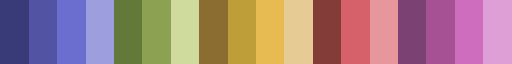

In [17]:
colormap

In [18]:
pivot_percentage

category  Liquid Staking    Lending  Restaking      Dexes  Liquid Restaking  \
chain                                                                         
Ethereum       33.086548  17.419289  11.933237   6.007576          9.344824   
Solana         45.358157  16.160944   2.244773  16.174709          0.000000   
Arbitrum        0.000000  25.727875   0.000000  15.843732          0.000000   
Base            3.049321  19.718726   0.000000  53.732729          0.000000   
Optimism        0.000000  25.459142   0.000000  18.347902          0.000000   
Mode            0.000000  74.268798   0.000000   4.314260          5.696259   

category     Yield     Bridge       RWA  Basis Trading       Farm  ...  \
chain                                                              ...   
Ethereum  4.375586   3.566052  0.000000            0.0   0.000000  ...   
Solana    0.000000   0.000000  0.000000            0.0   0.000000  ...   
Arbitrum  7.105739  19.884481  0.000000            0.0   0.000000  ...   
Base      0.000000   0.000000  3.363074            0.0   0.000000  ...   
Optimism  7.276311   0.000000  0.000000            0.0   0.000000  ...   
Mode      0.272002   0.000000  0.000000            0.0  14.846505  ...   

category  Uncollateralized Lending  Reserve Currency  OTC Marketplace  \
chain                                                                   
Ethereum                       0.0               0.0              0.0   
Solana                         0.0               0.0              0.0   
Arbitrum                       0.0               0.0              0.0   
Base                           0.0               0.0              0.0   
Optimism                       0.0               0.0              0.0   
Mode                           0.0               0.0              0.0   

category  DEX Aggregator  RWA Lending  Governance Incentives  \
chain                                                          
Ethereum             0.0          0.0                    0.0   
Solana               0.0          0.0                    0.0   
Arbitrum             0.0          0.0                    0.0   
Base                 0.0          0.0                    0.0   
Optimism             0.0          0.0                    0.0   
Mode                 0.0          0.0                    0.0   

category  Decentralized Stablecoin  Gaming  NftFi  Everything Else  
chain                                                               
Ethereum                       0.0     0.0    0.0        14.266888  
Solana                         0.0     0.0    0.0         3.648674  
Arbitrum                       0.0     0.0    0.0         9.970130  
Base                           0.0     0.0    0.0         6.679370  
Optimism                       0.0     0.0    0.0        14.655420  
Mode                           0.0     0.0    0.0         0.337524  

[6 rows x 46 columns]

In [19]:
import plotly.graph_objects as go

# Define the list of chains to include in the plot
chains_to_include = [ "Solana", "Superchain", "Arbitrum", "Base", "Optimism", "Mode"]

# Reset the index of `today_tvl_pivot` to make `chain` a column, then filter
pivot_table_reset = today_tvl_pivot.reset_index().sort_values(by="Grand Total", ascending=False)
pivot_filtered = pivot_table_reset.query("chain in @chains_to_include")

# Filter columns to include only the categories of interest
categories_to_plot = ["Native Asset", "Stablecoins", "Liquid Staking", "Liquid Restaking", "Wrapped Assets", "Other"]
pivot_filtered = pivot_filtered.set_index("chain")[categories_to_plot]

# Create the stacked bar plot
fig = go.Figure()

# Add a bar for each category to the stacked bar plot
for category in categories_to_plot:
    fig.add_trace(
        go.Bar(
            x=pivot_filtered.index,
            y=pivot_filtered[category],
            name=category
        )
    )

# Update layout for clarity and aesthetics
fig.update_layout(
    barmode="stack",  # Stacked bars
    title="USD Value by Chain and Token Category",
    xaxis_title="Chain",
    yaxis_title="Total USD Value",
    width=900,
    height=600,
    legend_title="Token Category",
    # yaxis_type="log",
    template="plotly_white"
)

# Show the plot
# fig.update_axes(type="log")
fig.show()


In [20]:

# Define the list of chains to include in the plot
chains_to_include = ["Ethereum", "Solana", "Superchain", "Arbitrum", "Base", "Optimism", "Mode"]

# Reset the index of `today_tvl_pivot` to make `chain` a column, then filter
pivot_table_reset = today_tvl_pivot.reset_index().sort_values(by="Grand Total", ascending=False)
pivot_filtered = pivot_table_reset.query("chain in @chains_to_include")

# Filter columns to include only the categories of interest
categories_to_plot = ["Native Asset", "Stablecoins", "Liquid Staking", "Liquid Restaking", "Wrapped Assets", "Other"]
pivot_filtered = pivot_filtered.set_index("chain")[categories_to_plot]

# Calculate percentages for each category within each chain
pivot_percentage = pivot_filtered.div(pivot_filtered.sum(axis=1), axis=0) * 100

# Create the percentage stacked bar plot
fig = go.Figure()

# Add a bar for each category to the stacked bar plot (now in percentage)
for category in categories_to_plot:
    fig.add_trace(
        go.Bar(
            x=pivot_percentage.index,
            y=pivot_percentage[category],
            name=category
        )
    )

# Update layout for clarity and aesthetics
fig.update_layout(
    barmode="stack",  # Stacked bars
    title="Percentage Breakdown of TVL by Chain and Token Category",
    xaxis_title="Chain",
    yaxis_title="Percentage of Total TVL (USD)",
    yaxis=dict(tickformat=".0f%"),  # Format y-axis as percentages
    width=900,
    height=600,
    legend_title="Token Category",
    template="plotly_white"
)

# Show the plot
fig.show()


In [21]:
today_tvl_pivot["lego_factor"] = today_tvl_pivot["Grand Total"] / today_tvl_pivot["tvl"]

In [22]:
today_tvl_pivot

chain  Liquid Restaking  Liquid Staking  Native Asset         Other  \
0      Arbitrum      4.030093e+08    2.120538e+08  4.595116e+08  7.001114e+08   
1           BOB               NaN    2.731357e+05  3.700784e+06  4.725743e+07   
2          Base      2.768576e+07    4.950411e+08  7.789916e+08  6.742517e+08   
3          Boba               NaN             NaN  7.910742e+03  8.344216e+05   
4         Cyber               NaN             NaN  0.000000e+00           NaN   
5      Ethereum      5.762507e+09    1.331991e+10  5.294460e+10  1.402803e+10   
6       Fraxtal      3.821638e+06    2.729524e+06  5.848816e+03  2.015084e+07   
7           Ham               NaN             NaN  1.072183e+04           NaN   
8         Kroma               NaN             NaN  9.068014e+04  3.061911e+06   
9          Lisk               NaN             NaN  5.316532e+05  2.987055e+05   
10         Mint               NaN             NaN  2.086389e+05           NaN   
11         Mode      2.295484e+07             NaN  1.173484e+07  6.816877e+06   
12     Optimism      3.515588e+07    1.000531e+08  9.315369e+07  2.601533e+08   
13   Polynomial               NaN             NaN           NaN  1.955534e+05   
14        Shape               NaN             NaN  2.494878e+05           NaN   
15       Solana      3.438486e+07    1.284451e+09  8.724170e+09  1.386425e+09   
16  World Chain               NaN             NaN  2.249924e+05  7.019664e+05   
17         Zora               NaN             NaN  1.183180e+05  7.065223e+04   
18  Grand Total      6.289519e+09    1.541451e+10  6.301732e+10  1.712836e+10   
19   Superchain      8.961812e+07    5.980969e+08  8.890292e+08  1.013793e+09   

     Stablecoins  Wrapped Assets   Grand Total           tvl  lego_factor  
0   1.210983e+09    4.948009e+08  3.480470e+09  2.292392e+09     1.518270  
1   2.122633e+06    3.389300e+07  8.724699e+07           NaN          NaN  
2   6.862601e+08    7.910304e+07  2.741333e+09  2.424272e+09     1.130786  
3   8.309116e+05    0.000000e+00  1.673244e+06           NaN          NaN  
4            NaN             NaN  0.000000e+00           NaN          NaN  
5   1.021777e+10    5.836041e+09  1.021089e+11  4.749254e+10     2.149998  
6   2.154942e+07    3.092421e+04  4.828819e+07           NaN          NaN  
7            NaN             NaN  1.072183e+04           NaN          NaN  
8   2.420601e+05             NaN  3.394651e+06           NaN          NaN  
9   8.289941e+04             NaN  9.132581e+05           NaN          NaN  
10  5.323224e+04    2.486728e+02  2.621198e+05           NaN          NaN  
11  4.264156e+06    2.255585e+08  2.713292e+08  2.200809e+08     1.232862  
12  2.280603e+08    6.029531e+07  7.768716e+08  6.167915e+08     1.259537  
13  2.036283e+06             NaN  2.231837e+06           NaN          NaN  
14           NaN             NaN  2.494878e+05           NaN          NaN  
15  8.512466e+08    1.325325e+08  1.241321e+10  6.042271e+09     2.054395  
16  5.684048e+05             NaN  1.495364e+06           NaN          NaN  
17  0.000000e+00             NaN  1.889703e+05           NaN          NaN  
18  1.322607e+10    6.862256e+09  1.219380e+11           NaN          NaN  
19  9.460704e+08    3.988811e+08  3.935489e+09  3.417920e+09     1.151428

In [23]:
# Define the list of chains to include in the plot
chains_to_include = ["Ethereum", "Solana", "Superchain", "Arbitrum", "Base", "Optimism", "Mode"]

# Reset the index of `today_tvl_pivot` to make `chain` a column, then filter
pivot_table_reset = today_tvl_pivot.reset_index().sort_values(by="lego_factor", ascending=False)
pivot_filtered = pivot_table_reset.query("chain in @chains_to_include")

# Filter columns to include only the categories of interest
categories_to_plot = ["lego_factor"]
pivot_filtered = pivot_filtered.set_index("chain")[categories_to_plot]

# Create the stacked bar plot
fig = go.Figure()

# Add a bar for each category to the stacked bar plot
for category in categories_to_plot:
    fig.add_trace(
        go.Bar(
            x=pivot_filtered.index,
            y=pivot_filtered[category],
            name=category
        )
    )

fig.add_shape(
    type="line",
    x0=-0.5,
    x1=len(pivot_filtered) - 0.5,
    y0=1, y1=1,
    line=dict(color="black", width=2, dash="dash"),
    xref="x",
    yref="y"
)

# Update layout for clarity and aesthetics
fig.update_layout(
    barmode="stack",  # Stacked bars
    title="How many times each dollar is counted in TVL (Lego Factor)",
    xaxis_title="Chain",
    yaxis_title="Duplicated TVL / De-Duplicated TVL (Lego Factor)",
    width=900,
    height=600,
    legend_title="Token Category",
    template="plotly_white"
)

# Show the plot
fig.show()


In [60]:
today_tvl_pivot["native_token_percentage"] = today_tvl_pivot["Native Asset"] / today_tvl_pivot["Grand Total"]

In [61]:
import plotly.express as px

# Extract the Native Asset and lego_factor columns from the pivot table for plotting
scatter_data = today_tvl_pivot[["Grand Total", "tvl"]].dropna()  # Drop rows with NaN values for cleaner plot

# Create the scatter plot
fig = px.scatter(
    scatter_data,
    x="tvl",
    y="Grand Total",
    title="Scatter Plot of Native Asset vs. Lego Factor",
    labels={"Native Asset": "Native Asset (USD Value)", "lego_factor": "Lego Factor"},
    template="plotly_white",
    width=700
)

# Show the plot
fig.show()


In [62]:
today_df[(today_df.chain == "Solana")][(today_df.token_category.isin(["Native Asset"]))].usd_value.sum()

np.float64(8724170231.66607)

In [63]:
today_df[(today_df.chain == "Ethereum")][(today_df.token.isin(["WETH"]))].usd_value.sum()

np.float64(52462745391.35033)

In [64]:
base_token_df = today_df[(today_df.chain == "Base")].groupby("token").agg(
    {"usd_value": "sum"}
).reset_index().sort_values(by="usd_value", ascending=False)

In [65]:
optimism_token_df = today_df[(today_df.chain == "Optimism")].groupby("token").agg(
    {"usd_value": "sum"}
).reset_index().sort_values(by="usd_value", ascending=False)

In [66]:
optimism_token_df[optimism_token_df.usd_value >= 5_000_000]

token     usd_value
297    USDT  1.496074e+08
255     SNX  1.039998e+08
348  WSTETH  9.112727e+07
292    USDC  7.370130e+07
337    WETH  6.557840e+07
324    WBTC  6.029531e+07
197      OP  3.432747e+07
293  USDC.E  2.975793e+07
107   EZETH  2.863758e+07
104     ETH  2.757529e+07
267    SUSD  1.737963e+07
308    VELO  6.387903e+06
228    RETH  5.775720e+06
94     DOLA  5.397013e+06

In [48]:
today_df[(today_df.chain == "Base")][(today_df.token.isin(["ETH", "WETH"]))].groupby("category").agg(
    {"usd_value": "sum"}
).reset_index().sort_values(by="usd_value", ascending=False)

category     usd_value
4               Dexes  5.238882e+08
8             Lending  1.229468e+08
10     Liquid Staking  8.359205e+07
7           Launchpad  3.114715e+07
9   Leveraged Farming  1.388439e+07
2         Cross Chain  1.215211e+07
24   Yield Aggregator  9.607198e+06
21               SoFi  3.173163e+06
23              Yield  2.785433e+06
22   Treasury Manager  9.350474e+05
1                 CDP  8.895731e+05
5              Gaming  5.156543e+05
11  Liquidity manager  4.432244e+05
20           Services  3.774126e+05
0              Bridge  3.359604e+05
15            Options  2.751314e+05
25      Yield Lottery  1.759235e+05
14    OTC Marketplace  4.807235e+04
17  Prediction Market  4.159925e+04
13    NFT Marketplace  8.958062e+03
18            Privacy  2.186039e+03
16           Payments  5.391254e+01
6             Indexes  4.976065e+01
12        NFT Lending  3.229750e+00
19                RWA  0.000000e+00
3         Derivatives -2.823360e+07

In [49]:
df_tvl = (
    df_filtered[["date", "chain", "parent_protocol", "usd_value"]]
    .groupby(["date", "chain", "parent_protocol"])
    .sum()
    .reset_index()
)

df_tvl["total_app_tvl_7d_avg"] = (
    df_tvl.groupby(["chain", "parent_protocol"])["usd_value"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

df_tvl["rank"] = df_tvl.groupby(["date", "chain"])["total_app_tvl_7d_avg"].rank(
    method="dense", ascending=False
)

df_tvl_filtered = df_tvl[df_tvl["rank"] <= 10].reset_index(drop=True)


In [50]:
df_tvl["date"] = pd.to_datetime(df_tvl["date"])

In [53]:
current_date = pd.to_datetime("2024-10-30")

# Filter DataFrame to include only relevant dates (base_date and offsets)
relevant_dates = [current_date - pd.Timedelta(days=offset) for offset in [7, 30, 90, 360]] + [current_date]
df_date_subset = df_tvl[df_tvl["date"].isin(relevant_dates)]

# Pivot to have dates as columns for each (chain, protocol) combination
df_pivot = df_date_subset.pivot_table(
    index=["chain", "parent_protocol"], 
    columns="date", 
    values="total_app_tvl_7d_avg"
).reset_index()

# Calculate percentage changes from base_date
tvl_metrics_df = pd.DataFrame({
    "chain": df_pivot["chain"],
    "parent_protocol": df_pivot["parent_protocol"],
    "7_day_change": (df_pivot[current_date] - df_pivot[current_date - pd.Timedelta(days=7)]) / df_pivot[current_date - pd.Timedelta(days=7)] * 100,
    "30_day_change": (df_pivot[current_date] - df_pivot[current_date - pd.Timedelta(days=30)]) / df_pivot[current_date - pd.Timedelta(days=30)] * 100,
    "90_day_change": (df_pivot[current_date] - df_pivot[current_date - pd.Timedelta(days=90)]) / df_pivot[current_date - pd.Timedelta(days=90)] * 100,
    "360_day_change": (df_pivot[current_date] - df_pivot[current_date - pd.Timedelta(days=360)]) / df_pivot[current_date - pd.Timedelta(days=360)] * 100,
})

KeyError: Timestamp('2024-08-01 00:00:00')

In [42]:
tvl_metrics_df = pd.merge(
    tvl_metrics_df,
    df_tvl[df_tvl.date == "2024-10-29"][["chain", "parent_protocol", "usd_value"]].rename(
        columns={"usd_value": "tvl"}
    ),
    on=["chain", "parent_protocol"],
    how="left",
)

In [71]:
tvl_metrics_df[
(tvl_metrics_df.chain == "Solana")
& (tvl_metrics_df.tvl >= 1_000_000)


].sort_values(by="90_day_change", ascending=False)

NameError: name 'tvl_metrics_df' is not defined

In [54]:
df_cat = (
    df_filtered[["date", "chain", "category", "usd_value"]]
    .groupby(["date", "chain", "category"])
    .sum()
    .reset_index()
)

df_cat["total_app_tvl_7d_avg"] = (
    df_cat.groupby(["chain", "category"])["usd_value"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

df_cat["rank"] = df_cat.groupby(["date", "chain"])["total_app_tvl_7d_avg"].rank(
    method="dense", ascending=False
)
df_cat["rank"] = df_cat["rank"].astype(int)

df_cat["category_ranked"] = df_cat["category"]
df_cat.loc[(df_cat["rank"] >= 16), "category_ranked"] = "Everything Else"

df_cat_agg = (
    df_cat[["date", "chain", "category_ranked", "usd_value"]]
    .groupby(["date", "chain", "category_ranked"])
    .sum()
    .reset_index()
)

In [55]:
df_cat_agg["total_app_tvl_7d_avg"] = (
    df_cat_agg.groupby(["chain", "category_ranked"])["usd_value"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

In [56]:
df_cat_agg = df_cat_agg.rename(columns={"category_ranked": "category"})

In [57]:
df_cat_agg[(df_cat_agg.chain == "Base") & (df_cat_agg.date == "2024-10-30")]

date chain           category     usd_value  total_app_tvl_7d_avg
10676  2024-10-30  Base                CDP  5.685149e+07          5.149750e+07
10677  2024-10-30  Base        Cross Chain  2.446260e+07          2.223561e+07
10678  2024-10-30  Base        Derivatives  8.137752e+07          7.234123e+07
10679  2024-10-30  Base              Dexes  1.699908e+09          1.636044e+09
10680  2024-10-30  Base    Everything Else  1.120129e+07          1.029687e+07
10681  2024-10-30  Base            Indexes  1.885469e+07          1.661270e+07
10682  2024-10-30  Base          Launchpad  3.730745e+07          3.605463e+07
10683  2024-10-30  Base            Lending  5.424519e+08          4.984087e+08
10684  2024-10-30  Base  Leveraged Farming  1.480350e+08          1.436837e+08
10685  2024-10-30  Base   Liquid Restaking  1.861498e+07          1.539698e+07
10686  2024-10-30  Base     Liquid Staking  9.332437e+07          9.474528e+07
10687  2024-10-30  Base                RWA  9.239996e+07          9.341070e+07
10688  2024-10-30  Base               SoFi  3.704205e+06          3.577532e+06
10689  2024-10-30  Base   Treasury Manager  5.816557e+06          5.828170e+06
10690  2024-10-30  Base              Yield  1.573803e+07          1.368972e+07
10691  2024-10-30  Base   Yield Aggregator  1.485373e+08          1.422961e+08

In [58]:
df_cat[(df_cat.chain == "Base") & (df_cat.date == "2024-10-30") & (df_cat.category_ranked == "Everything Else")].usd_value.sum()

np.float64(11201287.62054)

In [62]:
df_filtered["date"] = pd.to_datetime(df_filtered["date"])

In [63]:
df_category_breakdown = pd.merge(
    df_tvl,
    df_filtered[["date", "chain", "parent_protocol", "category"]].drop_duplicates(),
    on=["date", "chain", "parent_protocol"],
    how="left",
)

df_category_breakdown = df_category_breakdown[df_category_breakdown.usd_value >= 500_000]

df_category_tvl = (
    df_category_breakdown[["date", "chain", "category", "usd_value"]]
    .groupby(["date", "chain", "category"])
    .sum()
    .reset_index()
    .rename(columns={"usd_value": "cat_tvl"})
)

df_category_breakdown = pd.merge(df_category_breakdown, df_category_tvl, on=["date", "chain", "category"], how="left")
df_category_breakdown["category_percentage"] = df_category_breakdown.usd_value / df_category_breakdown.cat_tvl


df_category_breakdown["category_percentage_7d"] = df_category_breakdown.groupby(
    ["chain", "category", "parent_protocol"]
)["category_percentage"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

In [50]:
df_category_breakdown

date     chain  parent_protocol     usd_value  \
0      2023-11-04  Arbitrum         ACryptoS  7.379145e+05   
1      2023-11-04  Arbitrum      APX Finance  4.727963e+06   
2      2023-11-04  Arbitrum  Aboard Exchange  7.961314e+05   
3      2023-11-04  Arbitrum   Arbi's Finance  1.416374e+06   
4      2023-11-04  Arbitrum        Arbitrove  5.292580e+05   
...           ...       ...              ...           ...   
284158 2024-10-30    Solana   ribbon-finance  8.507223e+05   
284159 2024-10-30    Solana          sanctum  1.295780e+09   
284160 2024-10-30    Solana          sanctum  1.295780e+09   
284161 2024-10-30    Solana          sanctum  1.295780e+09   
284162 2024-10-30    Solana          stabble  1.685483e+06   

        total_app_tvl_7d_avg   rank           category       cat_tvl  \
0               7.379145e+05   99.0  Liquidity manager  2.283905e+07   
1               4.727963e+06   45.0        Derivatives  5.856634e+08   
2               7.961314e+05   95.0        Derivatives  5.856634e+08   
3               1.416374e+06   76.0              Yield  2.340344e+08   
4               5.292580e+05  112.0            Indexes  5.292580e+05   
...                      ...    ...                ...           ...   
284158          8.260541e+05   63.0      Options Vault  6.199742e+06   
284159          1.265911e+09    6.0     Liquid Staking  8.806782e+09   
284160          1.265911e+09    6.0              Dexes  3.107012e+09   
284161          1.265911e+09    6.0              Yield  1.337923e+09   
284162          1.811062e+06   54.0              Dexes  3.107012e+09   

        category_percentage  category_percentage_7d  
0                  0.032309                0.032309  
1                  0.008073                0.008073  
2                  0.001359                0.001359  
3                  0.006052                0.006052  
4                  1.000000                1.000000  
...                     ...                     ...  
284158             0.137219                0.136718  
284159             0.147134                0.149220  
284160             0.417050                0.355135  
284161             0.968502                0.968633  
284162             0.000542                0.000505  

[284163 rows x 10 columns]

In [67]:
df_cat["date"] = pd.to_datetime(df_cat["date"])

In [68]:
df_cat_breakdown = (
    df_filtered[["date", "chain", "category", "parent_protocol", "usd_value"]]
    .groupby(["date", "chain", "category", "parent_protocol"])
    .sum()
    .reset_index()
)

df_cat_breakdown = pd.merge(
    df_cat_breakdown,
    df_cat[["date", "chain", "category", "usd_value"]].rename(
        columns={"usd_value": "category_tvl"}
    ),
    on=["date", "chain", "category"],
    how="left",
)

# df_cat_breakdown["rank"] = df_cat_breakdown.groupby(
#     ["date", "chain", "category", "parent_protocol"]
# )["usd_value"].rank(method="dense", ascending=False)

# top_10_category_protocols = df_cat_breakdown[
#     (df_cat_breakdown["rank"] <= 10) & (df_cat_breakdown.date == df_cat_breakdown.date.max())
# ][["chain", "category", "parent_protocol"]]

# df_cat_breakdown_filtered = pd.merge(
#     df_cat_breakdown,
#     top_10_category_protocols,
#     on=["chain", "category", "parent_protocol"],
#     how="inner",
# )

df_cat_breakdown["category_percentage"] = df_cat_breakdown.usd_value / df_cat_breakdown.category_tvl


df_cat_breakdown["category_percentage_7d"] = df_cat_breakdown.groupby(
    ["chain", "category", "parent_protocol"]
)["category_percentage"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

In [69]:
df_cat_breakdown[
(df_cat_breakdown.date >= "2024-04-25")
& (df_cat_breakdown.date < "2024-05-15")
& (df_cat_breakdown.category == "Dexes")
& (df_cat_breakdown.chain == "Base")
].category_percentage.mean()

nan

In [70]:
aero_vs_everything_df = df_tvl.copy()

In [71]:
aero_vs_everything_df["protocol_breakdown"] = aero_vs_everything_df["parent_protocol"].apply(
    lambda x: "Aerodrome"
    if x == "aerodrome"
    else "Uniswap"
    if x == "uniswap"
    else "All Other Protocols"
)

aero_vs_everything_df_grouped = (
    aero_vs_everything_df.groupby(["date", "chain", "protocol_breakdown"])
    .agg({"usd_value": "sum"})
    .reset_index()
)

aero_vs_everything_df_grouped["total_app_tvl_7d_avg"] = aero_vs_everything_df_grouped.groupby(
    ["chain", "protocol_breakdown"]
)["usd_value"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

In [72]:
aero_breakdown = aero_vs_everything_df[
    (aero_vs_everything_df.chain == "Base") & (aero_vs_everything_df.date == "2024-10-30")
].groupby("protocol_breakdown").agg({"usd_value": "sum"})

In [73]:
def plot_tvl_over_time(df, chain_name, cat_col):
    """
    Plots the Total TVL over time for the top apps on a specified blockchain chain.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'total_app_tvl'.
        chain_name (str): The name of the chain to filter for (e.g., 'Base').

    Returns:
        None: Displays a line plot.
    """
    # Filter the DataFrame for the specified chain
    df_chain = df[df["chain"] == chain_name]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Plot each app's TVL over time
    for app in df_chain[cat_col].unique():
        app_data = df_chain[df_chain[cat_col] == app]
        plt.plot(app_data["date"], app_data["total_app_tvl_7d_avg"], label=app)

    # Add title, labels, and legend
    plt.title(f"Top Apps' Total TVL Over Time for '{chain_name}' Chain")
    plt.xlabel("Date")
    plt.ylabel("Total TVL")
    plt.legend(title="Parent Protocol", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Display the plot
    plt.tight_layout()
    plt.show()

In [74]:
def plotly_tvl_over_time(df, chain_name, cat_col):
    """
    Plots the Total TVL over time for the top apps on a specified blockchain chain.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'total_app_tvl'.
        chain_name (str): The name of the chain to filter for (e.g., 'Base').

    Returns:
        None: Displays an interactive Plotly line plot.
    """
    # Filter the DataFrame for the specified chain
    df_chain = df[df["chain"] == chain_name]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Initialize a Plotly figure
    fig = go.Figure()

    # Plot each app's TVL over time
    for app in df_chain[cat_col].unique():
        app_data = df_chain[df_chain[cat_col] == app]
        fig.add_trace(
            go.Scatter(
                x=app_data["date"],
                y=app_data["total_app_tvl_7d_avg"],
                mode="lines",
                name=app
            )
        )

    # Add title and axis labels
    fig.update_layout(
        title=f"App Total TVL Over Time for {chain_name}",
        xaxis_title="Date",
        yaxis_title="Total TVL",
        legend_title=cat_col,
        width=900,
        height=600,
        template="plotly_white"
    )

    # Display the Plotly figure
    fig.show()

In [75]:
# import plotly.graph_objects as go

# def plotly_tvl_percentage_over_time(df, chain_name, cat_col):
#     """
#     Plots the percentage Total TVL over time for the top apps on a specified blockchain chain.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'total_app_tvl_7d_avg'.
#         chain_name (str): The name of the chain to filter for (e.g., 'Base').
#         cat_col (str): The category column for the apps (e.g., 'parent_protocol').

#     Returns:
#         None: Displays an interactive Plotly stacked bar chart with percentages.
#     """
#     # Filter the DataFrame for the specified chain
#     df_chain = df[df["chain"] == chain_name]

#     # Check if there is data for the specified chain
#     if df_chain.empty:
#         print(f"No data available for chain: {chain_name}")
#         return

#     # Calculate the total TVL per date to get the percentage
#     df_chain["date_total"] = df_chain.groupby("date")["total_app_tvl_7d_avg"].transform("sum")
#     df_chain["percentage"] = (df_chain["total_app_tvl_7d_avg"] / df_chain["date_total"]) * 100

#     # Initialize a Plotly figure for a stacked bar chart
#     fig = go.Figure()

#     # Plot each app's percentage TVL over time as a stacked bar
#     for app in df_chain[cat_col].unique():
#         app_data = df_chain[df_chain[cat_col] == app]
#         fig.add_trace(
#             go.Bar(
#                 x=app_data["date"],
#                 y=app_data["percentage"],
#                 name=app
#             )
#         )

#     # Add title and axis labels
#     fig.update_layout(
#         barmode="stack",  # Stacked bars for percentage
#         title=f"Percentage of Total TVL Over Time for '{chain_name}' Chain",
#         xaxis_title="Date",
#         yaxis_title="Percentage of Total TVL (%)",
#         legend_title=cat_col,
#         yaxis=dict(tickformat=".0f"),
#         width=900,
#         height=600
#     )

#     # Display the Plotly figure
#     fig.show()

import plotly.graph_objects as go

def plotly_stacked_tvl_over_time(df, chain_name, cat_col, mode="percentage"):
    """
    Plots Total TVL over time for top apps on a specified blockchain chain in either percentage or stacked mode.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', category column, and 'total_app_tvl_7d_avg'.
        chain_name (str): The name of the chain to filter for (e.g., 'Base').
        cat_col (str): The category column to plot (e.g., 'parent_protocol').
        mode (str): Plot mode, either 'percentage' or 'stacked'. Default is 'percentage'.

    Returns:
        None: Displays an interactive Plotly bar chart.
    """
    # Filter the DataFrame for the specified chain
    df_chain = df[df["chain"] == chain_name]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Calculate the total TVL per date and normalize to get percentage (if mode is 'percentage')
    if mode == "percentage":
        # Group by date and calculate the total TVL for each date, then normalize per date
        df_chain["value"] = df_chain.groupby("date")["total_app_tvl_7d_avg"].transform(lambda x: x / x.sum() * 100)
        y_axis_title = "Percentage of Total TVL (%)"
        y_axis_format = ".0%"  # Format as percentage

        # Calculate cumulative percentage across the entire time range to determine top 10 categories
        category_totals = df_chain.groupby(cat_col)["value"].sum().nlargest(10)
        top_categories = category_totals.index
    else:
        df_chain["value"] = df_chain["total_app_tvl_7d_avg"]
        y_axis_title = "Total TVL"
        y_axis_format = "$,.0f"  # Format as dollar with thousand separators

        # For stacked mode, select the top 10 based on total value
        category_totals = df_chain.groupby(cat_col)["value"].sum().nlargest(10)
        top_categories = category_totals.index

    # Filter the DataFrame to include only the top 10 categories
    df_chain = df_chain[df_chain[cat_col].isin(top_categories)]

    # Initialize a Plotly figure for a stacked bar chart
    fig = go.Figure()

    # Plot only the top 10 categories' TVL over time as a stacked bar
    for category in top_categories:
        category_data = df_chain[df_chain[cat_col] == category]
        fig.add_trace(
            go.Bar(
                x=category_data["date"],
                y=category_data["value"],
                name=category
            )
        )

    # Set bar mode based on the input mode and update layout
    fig.update_layout(
        barmode="stack",  # Stacked bars for both 'percentage' and 'stacked' modes
        title=f"{mode.capitalize()} TVL Over Time for '{chain_name}' Chain",
        xaxis_title="Date",
        yaxis_title=y_axis_title,
        legend_title=cat_col,
        yaxis=dict(tickformat=y_axis_format, range=[0, 100] if mode == "percentage" else None),  # Limit y-axis to 0-100% for percentage mode
        width=900,
        height=600,
        template="plotly_white"
    )

    # Display the Plotly figure
    fig.show()



In [76]:
df_chain = df_cat[(df_cat["chain"] == "Base")]

# Check if there is data for the specified chain

# Calculate the total percentage across all dates for each app
app_totals = df_chain.groupby("category")["total_app_tvl_7d_avg"].sum()

In [77]:
app_totals

category
Bridge                      1.508617e+08
CDP                         5.816390e+09
Cross Chain                 2.208924e+09
Decentralized Stablecoin    1.788653e+08
Derivatives                 5.277107e+09
Dexes                       1.060893e+11
Gaming                      5.458854e+07
Indexes                     1.554754e+09
Insurance                   1.653450e+07
Launchpad                   3.335905e+09
Lending                     3.558147e+10
Leveraged Farming           1.083424e+10
Liquid Restaking            7.204392e+08
Liquid Staking              3.096408e+09
Liquidity manager           2.292686e+08
NFT Lending                 3.659367e+04
NFT Marketplace             5.436526e+05
OTC Marketplace             4.604576e+06
Options                     8.382799e+07
Payments                    2.681960e+06
Prediction Market           1.510907e+07
Privacy                     1.490450e+06
RWA                         6.221146e+09
Restaking                   4.751214e+04
Service

In [86]:
# import plotly.graph_objects as go


# def plotly_category_stacked_percentage(df, chain_name, graph_col):
#     """
#     Plots the percentage Total TVL over time for the top apps on a specified blockchain chain.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'category_percentage'.
#         chain_name (str): The name of the chain to filter for (e.g., 'Base').
#         category (str): The category column for the apps (e.g., 'parent_protocol').

#     Returns:
#         None: Displays an interactive Plotly stacked bar chart with percentages.
#     """
#     # Filter the DataFrame for the specified chain and category
#     df_chain = df[(df["chain"] == chain_name)]

#     # Check if there is data for the specified chain
#     if df_chain.empty:
#         print(f"No data available for chain: {chain_name}")
#         return

#     # Calculate the total percentage across all dates for each app
#     app_totals = df_chain.groupby(graph_col)["total_app_tvl_7d_avg"].sum()

#     # Select the top 10 categories by cumulative percentage
#     top_apps = app_totals.nlargest(10).index

#     # Initialize a Plotly figure for a stacked bar chart
#     fig = go.Figure()

#     # Plot each app's percentage TVL over time as a stacked bar
#     for app in df_chain["parent_protocol"].unique():
#         app_data = df_chain[df_chain["parent_protocol"] == app]
#         fig.add_trace(
#             go.Bar(
#                 x=app_data["date"],
#                 y=app_data["category_percentage"],
#                 name=app,
#                 showlegend=app in top_apps  # Show legend only for top 10 apps
#             )
#         )

#     # Add title and axis labels
#     fig.update_layout(
#         barmode="stack",  # Stacked bars for percentage
#         title=f"Percentage of Total TVL Over Time for '{chain_name}' Chain",
#         xaxis_title="Date",
#         yaxis_title="Percentage of Total TVL (%)",
#         legend_title=category,
#         yaxis=dict(tickformat=".0%"),
#         width=900,
#         height=600,
#         template="plotly_white"
#     )

#     # Display the Plotly figure
#     fig.show()



def plotly_app_stacked_percentage(df, chain_name, category):
    """
    Plots the percentage Total TVL over time for the top apps on a specified blockchain chain.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'category_percentage'.
        chain_name (str): The name of the chain to filter for (e.g., 'Base').
        category (str): The category column for the apps (e.g., 'parent_protocol').

    Returns:
        None: Displays an interactive Plotly stacked bar chart with percentages.
    """
    # Filter the DataFrame for the specified chain and category
    df_chain = df[(df["chain"] == chain_name) & (df["category"] == category)]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Calculate the total percentage across all dates for each app
    app_totals = df_chain.groupby("parent_protocol")["category_percentage"].sum()

    # Select the top 10 categories by cumulative percentage
    top_apps = app_totals.nlargest(10).index

    # Initialize a Plotly figure for a stacked bar chart
    fig = go.Figure()

    # Plot each app's percentage TVL over time as a stacked bar
    for app in df_chain["parent_protocol"].unique():
        app_data = df_chain[df_chain["parent_protocol"] == app]
        fig.add_trace(
            go.Bar(
                x=app_data["date"],
                y=app_data["category_percentage"],
                name=app,
                showlegend=app in top_apps  # Show legend only for top 10 apps
            )
        )

    # Add title and axis labels
    fig.update_layout(
        barmode="stack",  # Stacked bars for percentage
        title=f"Percentage of Total TVL Over Time for '{chain_name}' Chain",
        xaxis_title="Date",
        yaxis_title="Percentage of Total TVL (%)",
        legend_title=category,
        yaxis=dict(tickformat=".0%"),
        width=900,
        height=600,
        template="plotly_white"
    )

    # Display the Plotly figure
    fig.show()


In [79]:
import pandas as pd
import plotly.express as px


def plot_stacked_tvl_over_time(df, chain_name, cat_col):
    """
    Plots the percentage of Total TVL by category over time for a specified blockchain chain, with legend for only the top 10 categories by the last available date.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', category column, and 'total_app_tvl_7d_avg'.
        chain_name (str): The name of the chain to filter for (e.g., 'Ethereum').
        cat_col (str): The name of the column representing categories.

    Returns:
        None: Displays a stacked bar plot.
    """
    # Filter the DataFrame for the specified chain
    df_chain = df[df["chain"] == chain_name]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Group by date and category and sum the TVLs
    grouped = df_chain.groupby(["date", cat_col]).total_app_tvl_7d_avg.sum().reset_index()

    # Calculate the total TVL per date to find percentages
    total_per_date = grouped.groupby("date").total_app_tvl_7d_avg.transform("sum")

    # Calculate percentage
    grouped["percentage"] = 100 * grouped["total_app_tvl_7d_avg"] / total_per_date

    # Determine the maximum date
    max_date = grouped["date"].max()

    # Find the top 10 categories by percentage on the maximum date
    top_categories = (
        grouped[grouped["date"] == max_date]
        .sort_values(by="percentage", ascending=False)
        .head(10)[cat_col]
        .tolist()
    )

    # Plot using Plotly Express
    fig = px.bar(
        grouped,
        x="date",
        y="percentage",
        color=cat_col,
        labels={"percentage": "Percentage of Total TVL", cat_col: "Category"},
        title=f"Percentage of Total TVL by Category Over Time for {chain_name}",
        template="plotly_white",
        width=900,
        height=600,
    )
    fig.update_layout(barmode="stack", xaxis_title="Date", yaxis_title="Percentage of Total TVL")

    # Update legend to show only top 10 categories
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=True if trace.name in top_categories else False)
    )

    fig.show()


# Example usage:
# plot_tvl_over_time(your_dataframe, 'Ethereum', 'parent_protocol')


In [80]:
plotly_tvl_over_time(df_tvl, "Base", "parent_protocol")

In [81]:
plotly_tvl_over_time(df_cat_agg, "Base", "category", mode="stacked")

TypeError: plotly_tvl_over_time() got an unexpected keyword argument 'mode'

In [93]:
plotly_tvl_over_time(df_tvl_filtered, "Base", "parent_protocol")

In [166]:
plotly_tvl_over_time(aero_vs_everything_df_grouped, "Base", "protocol_breakdown")

In [220]:
plot_stacked_tvl_over_time(df_cat, "Base", "category")

In [ ]:
plotly_stacked_tvl_over_time()

In [32]:
plotly_tvl_percentage_over_time(aero_vs_everything_df_grouped, "Base", "protocol_breakdown")

In [83]:
plot_stacked_tvl_over_time(df_cat, "Base", "category")

In [174]:
plotly_app_stacked_percentage(df_cat_breakdown, "Base", "Dexes")

In [34]:
plotly_app_stacked_percentage(df_category_breakdown, "Base", "Lending")

In [35]:
plotly_app_stacked_percentage(df_category_breakdown, "Base", "Yield Aggregator")

In [31]:
plotly_tvl_over_time(df_cat, "Solana", "category")

In [87]:
plotly_app_stacked_percentage(df_category_breakdown, "Solana", "Liquid Staking")

In [84]:
plot_stacked_tvl_over_time(df_cat, "Solana", "category")

In [96]:
plotly_stacked_tvl_over_time(df_cat, "Ethereum", "category")

In [ ]:
plotly_stacked_tvl_over_time(df_cat_breakdown, "Ethereum", "category")

In [81]:
plotly_tvl_percentage_over_time(df_cat, "Fraxtal", "category")

In [107]:
plotly_tvl_over_time(df_category_breakdown[df_category_breakdown.category == "Liquid Staking"], "Ethereum", "parent_protocol")

In [120]:
df_token_breakdown = df_filtered[(df_filtered.chain == "Base")
            &(df_filtered.category == "")]

date  token   token_value     usd_value  total_app_tvl  \
0        2023-11-04   WETH  8.846468e+06  1.617241e+10   1.640234e+10   
1        2023-11-04  MATIC  1.456039e+08  9.713703e+07   1.640234e+10   
2        2023-11-05   WETH  8.857908e+06  1.639430e+10   1.689845e+10   
3        2023-11-05  MATIC  1.456755e+08  9.829322e+07   1.689845e+10   
4        2023-11-06   WETH  8.935691e+06  1.688149e+10   1.701443e+10   
...             ...    ...           ...           ...            ...   
15161397 2024-10-28   CDAI  1.024747e+06  2.440546e+04   2.454243e+04   
15161398 2024-10-29  AUSDC  1.369706e+02  1.369706e+02   2.455011e+04   
15161399 2024-10-29   CDAI  1.024747e+06  2.441314e+04   2.455011e+04   
15161400 2024-10-30  AUSDC  1.369779e+02  1.369168e+02   2.450916e+04   
15161401 2024-10-30   CDAI  1.024747e+06  2.437224e+04   2.450916e+04   

          latest_total_app_tvl    protocol        slug     chain  \
0                 2.613698e+10        lido        lido  Ethereum   
1                 2.613698e+10        lido        lido  Ethereum   
2                 2.613698e+10        lido        lido  Ethereum   
3                 2.613698e+10        lido        lido  Ethereum   
4                 2.613698e+10        lido        lido  Ethereum   
...                        ...         ...         ...       ...   
15161397          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161398          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161399          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161400          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161401          2.455237e+04  gooddollar  gooddollar  Ethereum   

                category        name parent_protocol  to_filter_out alignment  \
0         Liquid Staking        Lido            Lido              0       NaN   
1         Liquid Staking        Lido            Lido              0       NaN   
2         Liquid Staking        Lido            Lido              0       NaN   
3         Liquid Staking        Lido            Lido              0       NaN   
4         Liquid Staking        Lido            Lido              0       NaN   
...                  ...         ...             ...            ...       ...   
15161397           Yield  GoodDollar      GoodDollar              0       NaN   
15161398           Yield  GoodDollar      GoodDollar              0       NaN   
15161399           Yield  GoodDollar      GoodDollar              0       NaN   
15161400           Yield  GoodDollar      GoodDollar              0       NaN   
15161401           Yield  GoodDollar      GoodDollar              0       NaN   

         token_category  
0          Native Asset  
1                 Other  
2          Native Asset  
3                 Other  
4          Native Asset  
...                 ...  
15161397          Other  
15161398          Other  
15161399          Other  
15161400          Other  
15161401          Other  

[15161402 rows x 15 columns]

In [118]:
plotly_tvl_over_time(df_category_breakdown[df_category_breakdown.category == "Liquid Staking"], "Ethereum", "token")

KeyError: 'token'

In [89]:
plotly_app_stacked_percentage(df_category_breakdown, "Arbitrum", "Bridge")

In [82]:
plotly_app_stacked_percentage(df_category_breakdown, "Ethereum", "Liquid Staking")

NameError: name 'plotly_app_stacked_percentage' is not defined

In [114]:
plotly_app_stacked_percentage(df_category_breakdown, "Arbitrum", "Liquid Restaking")

In [101]:
plotly_app_stacked_percentage(df_category_breakdown, "Arbitrum", "Liquid Restaking")

In [195]:
df_filtered

date  token   token_value     usd_value  total_app_tvl  \
0        2023-11-04   WETH  8.846468e+06  1.617241e+10   1.640234e+10   
1        2023-11-04  MATIC  1.456039e+08  9.713703e+07   1.640234e+10   
2        2023-11-05   WETH  8.857908e+06  1.639430e+10   1.689845e+10   
3        2023-11-05  MATIC  1.456755e+08  9.829322e+07   1.689845e+10   
4        2023-11-06   WETH  8.935691e+06  1.688149e+10   1.701443e+10   
...             ...    ...           ...           ...            ...   
15161397 2024-10-28   CDAI  1.024747e+06  2.440546e+04   2.454243e+04   
15161398 2024-10-29  AUSDC  1.369706e+02  1.369706e+02   2.455011e+04   
15161399 2024-10-29   CDAI  1.024747e+06  2.441314e+04   2.455011e+04   
15161400 2024-10-30  AUSDC  1.369779e+02  1.369168e+02   2.450916e+04   
15161401 2024-10-30   CDAI  1.024747e+06  2.437224e+04   2.450916e+04   

          latest_total_app_tvl    protocol        slug     chain  \
0                 2.613698e+10        lido        lido  Ethereum   
1                 2.613698e+10        lido        lido  Ethereum   
2                 2.613698e+10        lido        lido  Ethereum   
3                 2.613698e+10        lido        lido  Ethereum   
4                 2.613698e+10        lido        lido  Ethereum   
...                        ...         ...         ...       ...   
15161397          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161398          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161399          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161400          2.455237e+04  gooddollar  gooddollar  Ethereum   
15161401          2.455237e+04  gooddollar  gooddollar  Ethereum   

                category        name parent_protocol  to_filter_out alignment  \
0         Liquid Staking        Lido            Lido              0       NaN   
1         Liquid Staking        Lido            Lido              0       NaN   
2         Liquid Staking        Lido            Lido              0       NaN   
3         Liquid Staking        Lido            Lido              0       NaN   
4         Liquid Staking        Lido            Lido              0       NaN   
...                  ...         ...             ...            ...       ...   
15161397           Yield  GoodDollar      GoodDollar              0       NaN   
15161398           Yield  GoodDollar      GoodDollar              0       NaN   
15161399           Yield  GoodDollar      GoodDollar              0       NaN   
15161400           Yield  GoodDollar      GoodDollar              0       NaN   
15161401           Yield  GoodDollar      GoodDollar              0       NaN   

         token_category  
0          Native Asset  
1                 Other  
2          Native Asset  
3                 Other  
4          Native Asset  
...                 ...  
15161397          Other  
15161398          Other  
15161399          Other  
15161400          Other  
15161401          Other  

[15161402 rows x 15 columns]

In [95]:
token_category_breakdown = df_filtered.groupby(["date", "chain", "token_category", "category"]).agg(
    {"usd_value": "sum"}
).reset_index()

In [96]:
superchain_category_breakdown = df_filtered[df_filtered.alignment == "OP Chain"].groupby(["date", "token_category", "category"]).agg(
    {"usd_value": "sum"}
).reset_index()

In [97]:
superchain_category_breakdown["chain"] = "Superchain"

In [98]:
token_category_breakdown = pd.concat([token_category_breakdown, superchain_category_breakdown])

In [99]:
token_category_breakdown.chain.unique()

array(['Arbitrum', 'BOB', 'Base', 'Boba', 'Cyber', 'Ethereum', 'Fraxtal',
       'Kroma', 'Mint', 'Mode', 'Optimism', 'Solana', 'Zora', 'Ham',
       'Polynomial', 'Lisk', 'Shape', 'World Chain', 'Superchain'],
      dtype=object)

In [100]:
token_category_breakdown[
    (token_category_breakdown.chain == "Ethereum")
    & (token_category_breakdown.date == "2024-10-30")
                         ].usd_value.sum()

np.float64(110338711144.7812)

In [101]:
token_category_breakdown

date       chain    token_category          category  \
0      2024-08-07    Arbitrum  Liquid Restaking            Bridge   
1      2024-08-07    Arbitrum  Liquid Restaking               CDP   
2      2024-08-07    Arbitrum  Liquid Restaking       CDP Manager   
3      2024-08-07    Arbitrum  Liquid Restaking       Derivatives   
4      2024-08-07    Arbitrum  Liquid Restaking             Dexes   
...           ...         ...               ...               ...   
12863  2024-11-06  Superchain    Wrapped Assets             Dexes   
12864  2024-11-06  Superchain    Wrapped Assets           Lending   
12865  2024-11-06  Superchain    Wrapped Assets          Payments   
12866  2024-11-06  Superchain    Wrapped Assets  Treasury Manager   
12867  2024-11-06  Superchain    Wrapped Assets             Yield   

          usd_value  
0      3.359168e+05  
1      8.517781e+05  
2      0.000000e+00  
3      4.322879e+07  
4      1.999811e+07  
...             ...  
12863  7.133042e+06  
12864  5.582019e+07  
12865  5.222430e+00  
12866  9.975274e+03  
12867  3.720165e+04  

[83443 rows x 5 columns]

In [102]:
!uv pip install squarify

Using Python 3.12.7 environment at /Users/chuck/codebase/op-analytics/.venv
Audited 1 package in 19ms


In [82]:
import squarify

In [103]:
import pandas as pd
import plotly.express as px


def plot_nested_token_category_breakdown(data, date, chain, date_diff=90):
    """
    Plots a nested treemap of 'usd_value' breakdown by 'category' within each 'token_category'
    for a specified 'date' and 'chain' in a single chart. Colors each block by the percentage
    growth in 'eth_value' from 'date_diff' days ago (default 90).

    Parameters:
    - data: DataFrame containing the dataset.
    - date: Specific date to filter the data.
    - chain: Specific blockchain to filter the data.
    - current_eth_price: Current USD price of 1 ETH.
    - previous_eth_price: USD price of 1 ETH from 'date_diff' days ago.
    - date_diff: Number of days to look back for growth calculation (default is 90).
    """
    # Convert date to datetime format
    data["date"] = pd.to_datetime(data["date"])
    target_date = pd.to_datetime(date)
    previous_date = target_date - pd.Timedelta(days=date_diff)

    # Filter data for the target date and chain, ensure usd_value >= 100000
    filtered_data = data[
        (data["date"] == target_date) & (data["chain"] == chain) & (data["usd_value"] >= 10_000)
    ]

    # Get previous data for calculating percent change
    previous_data = data[
        (data["date"] == previous_date) & (data["chain"] == chain) & (data["usd_value"] >= 10_000)
    ]

    # Merge to calculate the percent change in ETH value
    merged_data = filtered_data.merge(
        previous_data[["token_category", "category", "usd_value"]],
        on=["token_category", "category"],
        suffixes=("", "_previous"),
        how="left",
    )

    # Calculate percent change in ETH
    merged_data["percent_change"] = (
        (merged_data["usd_value"] - merged_data["usd_value_previous"])
        / merged_data["usd_value_previous"]
    ) * 100

    # Handle cases where there was no previous value
    merged_data["percent_change"].fillna(0, inplace=True)

    # Create the treemap with color based on percent change in ETH value and size by USD value
    fig = px.treemap(
        merged_data,
        path=[px.Constant("Total"), "token_category", "category"],
        values="usd_value",  # Bubble size by usd_value
        color="percent_change",  # Color by percent change in eth_value
        color_continuous_scale="RdBu",
        range_color=[-100, 100],  # Set range for red (decrease) to blue (increase)
        title=f"{chain}: Token Category <> App TVL Last {date_diff} Days",
        width=600,
        height=800,
    )

    # Update layout for better visualization
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

    # Show plot
    fig.show()


# Example usage:
# plot_nested_token_category_breakdown(token_category_breakdown, '2023-11-01', 'Ethereum', current_eth_price=3000, previous_eth_price=2500)


In [32]:
df_filtered[
    (df_filtered.chain == "Arbitrum")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")
].groupby(["token"]).agg({"usd_value": "sum"}).sort_values(
    by="usd_value", ascending=False
) / df_filtered[
    (df_filtered.chain == "Arbitrum")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")
].usd_value.sum()

usd_value
token           
USDC    0.814176
USDT    0.150508
FRAX    0.012764
DAI     0.011686
USDE    0.009944
USDS    0.000543
AGEUR   0.000185
TUSD    0.000107
USDD    0.000086

In [31]:
df_filtered[
    (df_filtered.chain == "Base")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")
].groupby(["token"]).agg({"usd_value": "sum"}).sort_values(
    by="usd_value", ascending=False
) / df_filtered[
    (df_filtered.chain == "Base")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")
].usd_value.sum()

usd_value
token           
USDC    0.785794
USDT    0.190245
EURC    0.022877
DAI     0.001084
AGEUR   0.000000

In [40]:
df_filtered[
    (df_filtered.chain == "Arbitrum")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")
    & (df_filtered.parent_protocol == "Hyperliquid Bridge")
].usd_value / df_filtered[
    (df_filtered.chain == "Arbitrum")
    & (df_filtered.token_category == "Stablecoins")
    & (df_filtered.date == "2024-10-30")].usd_value.sum()

932544    0.520477
Name: usd_value, dtype: float64

In [107]:
plot_nested_token_category_breakdown(token_category_breakdown, '2024-11-05', 'Arbitrum', 90)


In [116]:
plot_nested_token_category_breakdown(token_category_breakdown, '2024-10-30', 'Base', 30)


In [335]:
plot_nested_token_category_breakdown(token_category_breakdown, '2024-10-30', 'Solana', 30)


In [247]:
target_date = '2024-10-30'
chain = 'Base'
target_date = pd.to_datetime(target_date)
previous_date = target_date - pd.Timedelta(days=30)


In [249]:


# Filter data for the target date and chain, ensure usd_value >= 100000
filtered_data = token_category_breakdown[(token_category_breakdown['date'] == target_date) & (token_category_breakdown['chain'] == chain) & (token_category_breakdown['usd_value'] >= 10_000)]

# Get previous data for calculating percent change
previous_data = token_category_breakdown[(token_category_breakdown['date'] == previous_date) & (token_category_breakdown['chain'] == chain) & (token_category_breakdown['usd_value'] >= 10_000)]

# Merge to calculate the percent change in ETH value
merged_data = filtered_data.merge(
    previous_data[['token_category', 'category', 'usd_value']],
    on=['token_category', 'category'],
    suffixes=('', '_previous'),
    how='left'
)

# Calculate percent change in ETH
merged_data['percent_change'] = (
    (merged_data['usd_value'] - merged_data['usd_value_previous'])
    / merged_data['usd_value_previous']
) * 100

# Handle cases where there was no previous value
merged_data['percent_change'].fillna(0, inplace=True)

In [275]:
merged_data[merged_data.token_category == "Wrapped Assets"]

date chain  token_category           category     usd_value  \
69 2024-10-30  Base  Wrapped Assets             Bridge  4.840841e+05   
70 2024-10-30  Base  Wrapped Assets        Cross Chain  3.874430e+05   
71 2024-10-30  Base  Wrapped Assets        Derivatives  9.094683e+05   
72 2024-10-30  Base  Wrapped Assets              Dexes  8.906138e+06   
73 2024-10-30  Base  Wrapped Assets            Lending  3.821254e+07   
74 2024-10-30  Base  Wrapped Assets  Leveraged Farming  1.736669e+06   
75 2024-10-30  Base  Wrapped Assets            Options  3.248792e+05   
76 2024-10-30  Base  Wrapped Assets   Yield Aggregator  6.965101e+05   

       eth_value  usd_value_previous  percent_change  
69    182.673233                 NaN        0.000000  
70    146.204920                 NaN        0.000000  
71    343.195568        5.267349e+04     1626.614826  
72   3360.806771        3.179720e+07      -71.990808  
73  14419.825733        4.251459e+07      -10.119004  
74    655.346768        6.582660e+04     2538.247797  
75    122.595937                 NaN        0.000000  
76    262.833989                 NaN        0.000000

In [ ]:
merged_data

In [233]:
previous_date

Timestamp('2024-09-30 00:00:00')

In [221]:
filtered_data = token_category_breakdown[
    (token_category_breakdown["date"] == target_date) & (token_category_breakdown["chain"] == chain) & (token_category_breakdown["usd_value"] >= 100_000)
]
filtered_data["eth_value"] = filtered_data.usd_value / 2650

# Get previous data for calculating percent change
previous_data = token_category_breakdown[
    (token_category_breakdown["date"] == previous_date) & (token_category_breakdown["chain"] == chain) & (token_category_breakdown["usd_value"] >= 100_000)
]
previous_data["eth_value"] = previous_data.usd_value / 3204

merged_data = filtered_data.merge(
    previous_data[['token_category', 'category', "usd_value", 'eth_value']],
    on=['token_category', 'category'],
    suffixes=('', '_previous'),
    how='left'
)

# Calculate percent change in ETH
merged_data['percent_change'] = (
    (merged_data['eth_value'] - merged_data['eth_value_previous'])
    / merged_data['eth_value_previous']
) * 100

In [222]:
curr = merged_data[
    (merged_data.token_category == "Native Asset")


].eth_value.sum()

In [223]:
prev = merged_data[
    (merged_data.token_category == "Native Asset")


].eth_value_previous.sum()

In [232]:
curr

np.float64(284829.4856395585)

In [224]:
(curr - prev) / prev * 100

np.float64(44.7188509483736)

In [11]:
# Filter down for the visuals
# df_df.columns
# Test for errors
# df_df_all[(df_df_all['protocol'] == 'app_name') & (df_df_all['date'] == '2023-01-27')]

In [7]:
# df_df[(df_df['protocol'] == 'blast')].sort_values(by='date',ascending=False).head(10)

In [ ]:
df_df['date'] = pd.to_datetime(df_df['date'])

df_df = df_df[
    (df_df['date'] <= last_date) # filter out if date carries over too far
    & (df_df['date'] >= start_date - timedelta(days=1)) # filter down a bit so we can do trailing comparisons w/o doing every row
]  

In [9]:
# display(df_df_all)

# df_df_all2['token_value'] = df_df_all2['token_value'].fillna(0)
df_df.loc[:, 'token_value'] = df_df['token_value'].astype("float64")
df_df.loc[:, 'usd_value'] = df_df['usd_value'].astype("float64")
# display(df_df_all2)

In [10]:
# df_df[(df_df['protocol'] == 'blast')].sort_values(by='date',ascending=False).head(15)
# df_backup = df_df.copy()
# df_df = df_backup.copy()

In [11]:
# create an extra day to handle for tokens dropping to 0

df_df.fillna(0, inplace=True)
df_df["token"] = df_df["token"].astype(str).str.strip()
# df_df_shift_fwd = df_df.copy()
# df_df_shift_bwd = df_df.copy()
# df_df_shift_fwd['date'] = df_df_shift_fwd['date'] + timedelta(days=1)
# df_df_shift_bwd['date'] = df_df_shift_bwd['date'] - timedelta(days=1)
# df_df_shift = df_df_shift_fwd.copy()  # pd.concat([df_df_shift_fwd,df_df_shift_bwd])

df_df_shift = df_df.copy()
df_df_shift['date'] = df_df_shift['date'] + timedelta(days=1)


# del df_df_shift_fwd  # Free Up memory
#del df_df_shift_bwd #Free Up memory

In [12]:

# Use query for filtering instead of boolean indexing
df_df_shift = df_df_shift.query('date <= @last_date')
# df_df_shift = df_df_shift[
#     df_df_shift['date'] <= last_date
# ]  # filter out if date carries over too far
df_df_shift.loc[:, ["token_value", "usd_value"]] = 0.0

# merge back in
df_df = pd.concat([df_df, df_df_shift], sort=False) #don't sort for faster
del df_df_shift  # Free Up memory
# print(df_df_all.dtypes)

df_df = df_df.query('date <= @pd.Timestamp.today()')
# df_df = df_df[df_df['date'] <= pd.to_datetime("today")]


df_df = (df_df.fillna({'token_value': 0})
               .groupby(['date', "token", "chain", "protocol", "name", "category", "parent_protocol"])
               .sum(["usd_value", "token_value"])
               .reset_index())

# df_df["token_value"] = df_df["token_value"].fillna(0)
# df_df = df_df.groupby(
#     ['date', "token", "chain", "protocol", "name", "category", "parent_protocol"]
# ).sum(["usd_value", "token_value"])
# df_df = df_df.reset_index()

In [ ]:
print("done api")
# df_df_all = df_df_all.reset_index()
# df_df_all.head(15)
# df_df[(df_df['protocol'] == 'uniswap-v3')].sort_values(by='date',ascending=False).head(15)

In [14]:
# trailing comparison
df_df["last_token_value"] = df_df.groupby(["token", "protocol", "chain"])[
    "token_value"
].shift(1)
# now actually filter
df_df = df_df[df_df['date'] >= start_date]

In [15]:
# df_df[df_df['date'] == '2023-12-05']

# print(df_df[df_df['date'] == '2023-12-05'].sum())

In [16]:
data_df = df_df.copy()
del df_df  # Free up memory
data_df = data_df.sort_values(by='date')

# price = usd value / num tokens
data_df["price_usd"] = data_df["usd_value"] / data_df["token_value"]
data_df["last_price_usd"] = data_df.groupby(["token", "protocol", "chain"])[
    "price_usd"
].shift(1)

# If first instnace of token, make sure there's no price diff
data_df["last_price_usd"] = (
    data_df[["last_price_usd", "price_usd"]].bfill(axis=1).iloc[:, 0]
)
# Forward fill if token drops off
data_df["price_usd"] = data_df[["price_usd", "last_price_usd"]].bfill(axis=1).iloc[:, 0]

# data_df.sample(10)

In [17]:
# Find what is the latest token price. This sometimes gets skewed if tokens disappear or supply locked goes to 0

# Token's recency rank by chain - For calculating prices
data_df["token_rank_desc"] = (
    data_df.groupby(["chain", "token"])['date']
    .rank(method="dense", ascending=False)
    .astype(int)
)
# Token's recency rank by chain & app - For calculating prices
data_df["token_rank_desc_prot"] = (
    data_df.groupby(["chain", "token", "protocol"])['date']
    .rank(method="dense", ascending=False)
    .astype(int)
)
# Token's recency rank by chain & app if > 0 - For calculating prices
# data_df['token_rank_desc_prot_gt0'] = data_df[data_df['token_value'] > 0]\
#                                     .groupby(['chain', 'token', 'protocol'])['date']\
#                                     .rank(method='first', ascending=False).astype(int)

# get latest price either by protocol or in aggregate
# if we don't have a match by protocol, then select in aggregate.
# This section is messy

In [ ]:
prices_df = data_df[["chain", "protocol", "token"]].drop_duplicates()


latest_prices_df_raw_prot = data_df.loc[~data_df["price_usd"].isna()][
    ["token", "chain", "protocol", "price_usd"]
][data_df["token_rank_desc_prot"] == 1]
latest_prices_df_prot = latest_prices_df_raw_prot.groupby(
    ["token", "chain", "protocol"]
).median("price_usd")
latest_prices_df_prot = latest_prices_df_prot.rename(
    columns={"price_usd": "latest_price_usd_prot"}
)
latest_prices_df_prot = latest_prices_df_prot.reset_index()
prices_df = prices_df.merge(
    latest_prices_df_prot, on=["token", "chain", "protocol"], how="left"
)
del latest_prices_df_raw_prot  # Free up memory
print("done latest_prices_df_raw_prot")

latest_prices_df_raw = data_df.loc[~data_df["price_usd"].isna()][
    ["token", "chain", "price_usd"]
][data_df["token_rank_desc"] == 1]
latest_prices_df = latest_prices_df_raw.groupby(["token", "chain"]).median("price_usd")
latest_prices_df = latest_prices_df.rename(
    columns={"price_usd": "latest_price_usd_raw"}
)
latest_prices_df = latest_prices_df.reset_index()
prices_df = prices_df.merge(latest_prices_df, on=["token", "chain"], how="left")
del latest_prices_df  # Free up memory
print("done latest_prices_df")

prices_df["latest_price_usd_prot_gt0"] = 0
# latest_prices_df_raw_prot_gt0 = data_df.loc[~data_df['price_usd'].isna()][['token','chain','price_usd','protocol']][data_df['token_rank_desc_prot_gt0'] ==1]
# latest_prices_df_prot_gt0 = latest_prices_df_raw_prot_gt0.groupby(['token','chain','protocol']).median('price_usd')
# latest_prices_df_prot_gt0 = latest_prices_df_prot_gt0.rename(columns={'price_usd':'latest_price_usd_prot_gt0'})
# latest_prices_df_prot_gt0 = latest_prices_df_prot_gt0.reset_index()
# prices_df = prices_df.merge(latest_prices_df_prot_gt0,on=['token','chain','protocol'], how='left')
# latest_prices_df_prot_gt0 = None # Free up memory
# print('done latest_prices_df_prot_gt0')

In [ ]:
# prices_df['latest_price_usd'] = \
#         prices_df['latest_price_usd_prot'].where(prices_df['latest_price_usd_prot'] > 0, \
#         prices_df['latest_price_usd_raw'].where(prices_df['latest_price_usd_raw'] > 0, \
#         prices_df['latest_price_usd_prot_gt0']))

# Select the latest price we want in priority order

# Chat GPT did this logic
# Define the conditions and choices for the numpy.select() function
conditions = [
    prices_df["latest_price_usd_prot"] > 0,
    prices_df["latest_price_usd_raw"] > 0,
]
choices = [
    prices_df["latest_price_usd_prot"],
    prices_df["latest_price_usd_raw"],
]

# If both conditions are False, choose prices_df['latest_price_usd_prot_gt0']
default_choice = prices_df["latest_price_usd_prot_gt0"]

# Use numpy.select() to select the latest price
prices_df["latest_price_usd"] = np.select(conditions, choices, default_choice)

# if Latest price is way larger or smaller than last price, fall back on last price (likely token symbol dupes)

print("done price choice")


# Filter down
prices_df = prices_df[["chain", "protocol", "token", "latest_price_usd"]]

prices_df = prices_df[~prices_df["latest_price_usd"].isna()]

# Merge back in to the data dataframe
data_df = data_df.merge(prices_df, on=["token", "chain", "protocol"], how="left")
del prices_df  # Free Up memory
print("prices map done")

In [20]:
# Fix Price Choice Errors

data_df["price_multiple_ratio"] = data_df[["latest_price_usd", "last_price_usd"]].max(
    axis=1
) / data_df[["latest_price_usd", "last_price_usd"]].min(axis=1)

data_df["latest_price_usd"] = np.where(
    data_df["price_multiple_ratio"] > 1000,  # 1000x error bar for bad price
    data_df["last_price_usd"],
    data_df["latest_price_usd"],
)

In [ ]:
# Sort in date order

data_df.sort_values(by='date', inplace=True)

data_df["multiple_ratio"] = data_df[["price_usd", "last_price_usd"]].max(
    axis=1
) / data_df[["price_usd", "last_price_usd"]].min(axis=1)

# get net token change
data_df["net_token_flow"] = data_df["token_value"] - data_df["last_token_value"]
# get net token change * current price
data_df["net_dollar_flow"] = data_df["net_token_flow"] * data_df["price_usd"]
# get net token change * latest price
data_df["net_dollar_flow_latest_price"] = (
    data_df["net_token_flow"] * data_df["latest_price_usd"]
)

# Filter out weird errors and things
data_df = data_df[
    abs(data_df["net_dollar_flow"]) < 50_000_000_000
]  # 50 bil error bar for bad prices
data_df = data_df[data_df["multiple_ratio"] < 1000]  # 1000x error bar for bad prices
data_df = data_df[~data_df["net_dollar_flow"].isna()]

print('flow columns done')

In [22]:
# data_df[ (data_df['protocol'] == 'sushi-bentobox') & (data_df['date'] >= '2023-09-10') & (data_df['chain'] == 'Ethereum') & (data_df['token'] == 'VOLT') ]#.sort_values(by='net_dollar_flow_latest_price',ascending=True)

In [23]:
# data_df[(data_df['protocol'] == 'uniswap-v3')].sort_values(by=['date','net_dollar_flow_latest_price'],ascending=[False,False]).head(50)
# # data_df
# data_df[ (data_df['protocol'] == 'sushi-bentobox') & (data_df['date'] == '2023-09-11') & (data_df['chain'] == 'Ethereum') ].sort_values(by='net_dollar_flow_latest_price',ascending=True)

In [24]:
# data_df[(data_df['protocol'] == 'uniswap-v3')].groupby(['date','chain']).sum().tail(20)

In [ ]:
# Handle for errors where a token price went to zero (i.e. magpie ANKRBNB 2023-01-27)
data_df["net_dollar_flow_latest_price"] = np.where(
    data_df["net_dollar_flow"] == 0, 0, data_df["net_dollar_flow_latest_price"]
)

print('latest price filter done')

In [ ]:
# Get net flows by protocol

netdf_df = data_df[
    [
        'date',
        "protocol",
        "chain",
        "name",
        "category",
        "parent_protocol",
        "net_dollar_flow",
        "usd_value",
        "net_dollar_flow_latest_price",
    ]
]

del data_df  # Free Up memory

netdf_df = netdf_df.fillna(0)
netdf_df = netdf_df.sort_values(by='date', ascending=True)
netdf_df = netdf_df.groupby(
    ['date', "protocol", "chain", "name", "category", "parent_protocol"]
).sum(
    ["net_dollar_flow", "usd_value", "net_dollar_flow_latest_price"]
)  ##agg by app

# usd_value is the TVL on a given day
netdf_df = netdf_df.groupby(
    ['date', "protocol", "chain", "usd_value", "name", "category", "parent_protocol"]
).sum(["net_dollar_flow", "net_dollar_flow_latest_price"])

netdf_df.reset_index(inplace=True)
netdf_df.head()

# Drop index column if it exists
try:
    netdf_df.drop(columns=["index"], inplace=True)
except:
    pass
# display(netdf_df[netdf_df['protocol']=='makerdao'])

print('flows sum done')

In [ ]:
# get latest
netdf_df["rank_desc"] = (
    netdf_df.groupby(["protocol", "chain"])['date']
    .rank(method="dense", ascending=False)
    .astype(int)
)
# display(netdf_df[netdf_df['protocol'] == 'lyra'])
# display(netdf_df[netdf_df['protocol']=='makerdao'])

print('rank done')

In [28]:
# netdf_df.columns

for i in ("svg", "png", "html"):
    dir_path = "img_outputs/" + i
    # clear out folder
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    # create folder
    os.mkdir(dir_path)

In [29]:
summary_df = netdf_df.copy()

del netdf_df #Free Up memory

summary_df = summary_df.sort_values(by='date', ascending=True)

# Mark at latest price if chosen
if mark_at_latest_price == 1:
    summary_df["mark_at_latest_price"] = mark_at_latest_price
    summary_df["net_dollar_flow"] = summary_df["net_dollar_flow_latest_price"]
    titleval_append = " - At Latest Prices"
else:
    titleval_append = ""

# Cast 'net_dollar_flow' to float64 data type
summary_df["net_dollar_flow"] = summary_df["net_dollar_flow"].astype("float64")

summary_df["cumul_net_dollar_flow"] = (
    summary_df[["protocol", "chain", "net_dollar_flow"]]
    .groupby(["protocol", "chain"])
    .cumsum()
)
summary_df["flow_direction"] = np.where(
    summary_df["cumul_net_dollar_flow"] * 1.0 >= 0, 1, -1
)

summary_df["abs_cumul_net_dollar_flow"] = summary_df["cumul_net_dollar_flow"].abs()

# Loop through drange and calculate rolling sums and means
for i in drange:
    if i == 0:
        continue

    col_str = f"cumul_net_dollar_flow_{i}d"
    tvl_str = f"daily_avg_tvl_{i}d"

    # Calculate rolling sum for net_dollar_flow
    summary_df[col_str] = summary_df.groupby(["protocol", "chain"])["net_dollar_flow"].transform(
        lambda x: x.rolling(i, min_periods=1).sum()
    )

    # Calculate rolling mean for usd_value
    summary_df[tvl_str] = summary_df.groupby(["protocol", "chain"])["usd_value"].transform(
        lambda x: x.rolling(i, min_periods=1).mean()
    )

    summary_df[f"flow_direction_{i}d"] = np.where(summary_df[col_str] >= 0, 1, -1)
    summary_df[f"abs_cumul_net_dollar_flow_{i}d"] = summary_df[col_str].abs()

# Calculate percentage of TVL
summary_df["pct_of_tvl"] = 100 * summary_df["net_dollar_flow"] / summary_df["usd_value"]

# Filter final summary DataFrame
final_summary_df = summary_df[
    (summary_df["rank_desc"] == 1) & 
    (summary_df['date'] >= pd.to_datetime("today") - timedelta(days=7))
]
final_summary_df = final_summary_df[final_summary_df["cumul_net_dollar_flow"] < 1e20]

# # Create necessary directories
# os.makedirs("csv_outputs", exist_ok=True)
# os.makedirs("img_outputs/png", exist_ok=True)
# os.makedirs("img_outputs/svg", exist_ok=True)
# os.makedirs("img_outputs/html", exist_ok=True)

# # Save final summary DataFrame to CSV
# final_summary_df.to_csv("csv_outputs/latest_tvl_app_trends.csv", mode="w", index=False, encoding="utf-8")

In [ ]:
# upload to dune
d.write_dune_api_from_pandas(final_summary_df, "defillama_app_net_flows"
                                , "Defillama Net App Flows, apps with > $" + str(min_tvl/1e6) + "M TVL currently.")

In [ ]:
print("starting chart outputs")
# display(summary_df)
for i in drange:
    fig = ""
    if i == 0:
        yval = "abs_cumul_net_dollar_flow"
        hval = "cumul_net_dollar_flow"
        cval = "flow_direction"
        saveval = "net_app_flows"
        saveval_app = "net_app_flows_by_app"
        titleval = (
            "App Net Flows Change by Chain -> App - Last "
            + str(trailing_num_days)
            + " Days - (Apps with > $"
            + str(min_tvl / 1e6)
            + "M TVL Shown)"
            + titleval_append
        )
        titleval_app = (
            "App Net Flows Change by App -> Chain - Last "
            + str(trailing_num_days)
            + " Days - (Apps with > $"
            + str(min_tvl / 1e6)
            + "M TVL Shown)"
            + titleval_append
        )
    else:
        yval = "abs_cumul_net_dollar_flow_" + str(i) + "d"
        hval = "cumul_net_dollar_flow_" + str(i) + "d"
        cval = "flow_direction_" + str(i) + "d"
        saveval = "net_app_flows_" + str(i) + "d"
        saveval_app = "net_app_flows_by_app_" + str(i) + "d"
        titleval = (
            "App Net Flows Change by Chain -> App - Last "
            + str(i)
            + " Days - (Apps with > $"
            + str(min_tvl / 1e6)
            + "M TVL Shown)"
            + titleval_append
        )
        titleval_app = (
            "App Net Flows Change by App -> Chain - Last "
            + str(i)
            + " Days - (Apps with > $"
            + str(min_tvl / 1e6)
            + "M TVL Shown)"
            + titleval_append
        )
    if is_fallback_on_raw_tvl:
        subtitle = "<br><sup>Source: DefiLlama API | *For apps where DefiLlama didn't have flows by token, we use their total change in TVL (including token price change)</sup>"
    else:
        subtitle = ""

    fig = px.treemap(
        final_summary_df[final_summary_df[yval] != 0],
        path=[
            px.Constant("all"),
            "chain",
            "protocol",
        ],  #                  path=[px.Constant("all"), 'token', 'chain', 'protocol'], \
        values=yval,
        color=cval
        #                 ,color_discrete_map={'-1':'red', '1':'green'})
        ,
        color_continuous_scale="Spectral",
        title=titleval + subtitle,
        hover_data=[hval],
    )

    fig_app = px.treemap(
        final_summary_df[final_summary_df[yval] != 0],
        path=[
            px.Constant("all"),
            "protocol",
            "chain",
        ],  #                  path=[px.Constant("all"), 'token', 'chain', 'protocol'], \
        values=yval,
        color=cval
        #                 ,color_discrete_map={'-1':'red', '1':'green'})
        ,
        color_continuous_scale="Spectral",
        title=titleval_app + subtitle,
        hover_data=[hval],
    )

    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    fig_app.update_traces(root_color="lightgrey")
    fig_app.update_layout(margin=dict(t=50, l=25, r=25, b=25))

    # fig.write_image("img_outputs/svg/" + saveval + ".svg")  #
    # fig.write_image("img_outputs/png/" + saveval + ".png")  #
    fig.write_html("img_outputs/html/" + saveval + ".html", include_plotlyjs="cdn")

    # fig_app.write_image("img_outputs/svg/" + saveval_app + ".svg")  #
    # fig_app.write_image("img_outputs/png/" + saveval_app + ".png")  #
    fig_app.write_html(
        "img_outputs/html/" + saveval_app + ".html", include_plotlyjs="cdn"
    )

    if i == 30:
        fig.show()
# fig.data[0].textinfo = 'label+text+value'
# fig.update_layout(tickprefix = '$')

In [32]:
# final_summary_df.dtypes
# final_summary_df.sample(5)

In [ ]:
#BQ Upload
bqu.write_df_to_bq_table(final_summary_df, 'latest_defillama_tvl_app_trends')